In [ ]:
import pandas as pd
import numpy as np
import copy
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from optuna.trial import Trial
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, LeaveOneOut, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn import preprocessing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
filename = './머신러닝데이터.xlsx'

In [ ]:
# Imputation한 데이터를 불러온다
scoring_transition_1 = pd.read_excel(filename, sheet_name='scoring_result_merged', engine='openpyxl')
scoring_transition_0 = pd.read_excel(filename, sheet_name='scoring_origin', engine='openpyxl')
task_completion_time = pd.read_excel(filename, sheet_name='task_completion_time_mean_imput', engine='openpyxl')
sms_reply = pd.read_excel(filename, sheet_name='SMS_reply', engine='openpyxl')
weather_searching_site_region = pd.read_excel(filename, sheet_name='weather_searching_사이트주소', engine='openpyxl')

# 모든 Feature List
sms_reply, weather_searching_사이트주소는 feature 리스트가 같습니다

In [ ]:
# scoring = ['Routine_Screen_Unlock_Pattern', 'Routine_Phone_Register', 'Routine_Phone_Receive', 'Routine_SMS_Reply', 'Routine_Camera', 
# 'Routine_Location_Searching', 'Routine_Weather_Searching', 'Routine_Transfer', 'Routine_Location_Switching', 'Routine_Weather_Switching', 
# 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 'Transition_Camera', 'Transition_Location_Searching', 
# 'Transition_Weather_Searching', 'Transition_Transfer', 'Transition_Location_Switching', 'Transition_Weather_Switching', 'Result_Phone_Register', 
# 'Result_Phone_Receive', 'Result_SMS_Reply', 'Result_Camera', 'Result_Location_Searching', 'Result_Weather_Searching', 'Result_Transfer', 
# 'Result_Location_Switching', 'Result_Weather_Switching', 'routine_sum_trial', 'transition_sum_trial', 'result_sum_trial', 'all_sum_trial']

# task = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_total_time_nt', 
# 'phone_register_screen_unlocking_time', 'phone_register_sms_start_time', 'phone_register_instruction_check_time', 'phone_register_total_time', 
# 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_noti response', 'phone_receive_total_time_nt', 'phone_receive_total_time', 
# 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_noti_response_time', 'sms_reply_total_time_nt', 'sms_reply_compeltion_time', 
# 'sms_reply_total_time', 'camera_noti_response', 'camera_total_time_nt', 'camera_instruction_check_time', 'camera_total_time', 'camera_taken_time', 
# 'camera_gallery_delete_time', 'transfer_noti_response_time', 'transfer_total_time_nt', 'transfer_instruction_check_time', 'transfer_total_time', 
# 'transfer_usage_time', 'transfer_share_time', 'weather_searching_noti_response', 'weather_searching_total_time_nt', 'weather_searching_instruction_check_time', 
# 'weather_searching_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_switching_notification_response_time', 
# 'weather_switching_total_time_nt', 'weather_switching_instruction_check_time', 'weather_switching_total_time', 
# 'weather_switching_first_searching_keyword_typing_time', 'weather_switching_second_searching_keyword_typing_time', 
# 'weather_switching_information_searching_time', 'weather_switching_information_sharing_texting_time', 'location_searching_noti_response_time', 
# 'location_searching_total_time_nt', 'location_searching_instruction_check_time', 'location_searching_total_time', 'location_searching_food_typing_time', 
# 'location_searching_foodtyping_mapfinding_time', 'location_searching_mapfinding_time', 'location_searching_route_sharing_texting_time', 
# 'location_switching_notification_response', 'location_switching_total_time_nt', 'location_switching_instruction_check', 'location_switching_total_time', 
# 'location_switching_first_map_typing_time', 'location_switching_second_map_typing_time', 'location_switching_map_finding_time', 
# 'location_switching_map_route_sharing_time']

# sms_and_ws = ['average intercharacter time', 'std intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
# 'total_time (S)', 'total_count', 'IS (C+IF+INF+F)', 'backspace (F)', 'C', 'IF', 'INF', 'Shift', 'ISø (IS+S)', 'T (total_count-F)', 'WPS', 'WPM', 'AdjWPS', 
# 'AdjWPM', 'CPS', 'KSPS', 'GPS', 'KSPC', 'GPC', 'MSD', 'COER', 'UER', 'TER', 'CE', 'PC', 'UB', 'WB', 'CPC']

In [ ]:
# BAC column만 가져온다(Label)
y = scoring_transition_1['BAC']

# Participant, BAC column을 제거한다
scoring_transition_1 = scoring_transition_1.drop(['Participant', 'BAC'], axis=1)
scoring_transition_0 = scoring_transition_0.drop(['Participant', 'BAC'], axis=1)
task_completion_time = task_completion_time.drop(['Participant', 'BAC'], axis=1)
sms_reply = sms_reply.drop(['Participant', 'BAC'], axis=1)
weather_searching_site_region = weather_searching_site_region.drop(['Participant', 'BAC'], axis=1)

In [ ]:
# 라벨 3개용 features
# 각 데이터별로 필요한 column들만 뽑는다
scoring_transition_1_columns = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial']

scoring_transition_0_columns = []

task_completion_time_columns = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

In [ ]:
# 라벨을 2개용 features
scoring_transition_1_columns_two_label = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial']

scoring_transition_0_columns_two_label = []

task_completion_time_columns_two_label = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

In [ ]:
# 위에서 정한 feature들로 각각의 데이터 프레임을 생성한다
scoring_transition_1_df = scoring_transition_1[scoring_transition_1_columns]
scoring_transition_0_df = scoring_transition_0[scoring_transition_0_columns]
task_completion_time_df = task_completion_time[task_completion_time_columns]
sms_reply_df = sms_reply[sms_reply_columns]
weather_searching_site_region_df = weather_searching_site_region[weather_searching_site_region_columns]

scoring_transition_1_df_two_label = scoring_transition_1[scoring_transition_1_columns_two_label]
scoring_transition_0_df_two_label = scoring_transition_0[scoring_transition_0_columns_two_label]
task_completion_time_df_two_label = task_completion_time[task_completion_time_columns_two_label]
sms_reply_df_two_label = sms_reply[sms_reply_columns_two_label]
weather_searching_site_region_df_two_label = weather_searching_site_region[weather_searching_site_region_columns_two_label]

# feature명 수정하기
위에서 적은 feature명을 그대로 복사해서 가져온 다음 바꾸려는 feature만 수정하면 됩니다

In [ ]:
# 라벨 3개용 features의 feature명을 수정한다!
scoring_transition_1_columns = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial']

scoring_transition_0_columns = []

task_completion_time_columns = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

scoring_transition_1_df.columns = scoring_transition_1_columns
scoring_transition_0_df.columns = scoring_transition_0_columns
task_completion_time_df.columns = task_completion_time_columns
sms_reply_df.columns = sms_reply_columns
weather_searching_site_region_df.columns = weather_searching_site_region_columns

In [ ]:
# 라벨을 2개용 features의 feature명을 수정한다!
scoring_transition_1_columns_two_label = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial']

scoring_transition_0_columns_two_label = []

task_completion_time_columns_two_label = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

scoring_transition_1_df_two_label.columns = scoring_transition_1_columns_two_label
scoring_transition_0_df_two_label.columns = scoring_transition_0_columns_two_label
task_completion_time_df_two_label.columns = task_completion_time_columns_two_label
sms_reply_df_two_label.columns = sms_reply_columns_two_label
weather_searching_site_region_df_two_label.columns = weather_searching_site_region_columns_two_label

In [ ]:
# sms reply와 weather searching 사이트 주소의 feature명이 똑같으므로 feature명을 수정한다
sms_reply_df_columns = ['sms_' + col_name for col_name in sms_reply_df.columns] # sms reply feature 이름 앞에 sms_를 붙인다
weather_searching_site_region_df_columns = ['ws_' + col_name for col_name in weather_searching_site_region_df.columns] # ws feature 이름 앞에 ws_를 붙인다

sms_reply_df.columns = sms_reply_df_columns # 수정된 sms reply feature명을 적용한다
weather_searching_site_region_df.columns = weather_searching_site_region_df_columns # 수정된 ws feature명을 적용한다

# 위와 동일하게 작동한다
sms_reply_df_two_label_columns = ['sms_' + col_name for col_name in sms_reply_df_two_label.columns]
weather_searching_site_region_df_two_label_columns = ['ws_' + col_name for col_name in weather_searching_site_region_df_two_label.columns]

sms_reply_df_two_label.columns = sms_reply_df_two_label_columns
weather_searching_site_region_df_two_label.columns = weather_searching_site_region_df_two_label_columns

### merged_df : Label 3개인 데이터 집합
### merged_df_two_label : Label 2개인 데이터 집합

In [ ]:
# 필요한 데이터 프레임들을 합친다
merged_df_list = [scoring_transition_1_df, scoring_transition_0_df, task_completion_time_df, sms_reply_df, weather_searching_site_region_df]
merged_df_list_two_label = [scoring_transition_1_df_two_label, scoring_transition_0_df_two_label, task_completion_time_df_two_label, 
sms_reply_df_two_label, weather_searching_site_region_df_two_label]

merged_df = pd.concat(merged_df_list, axis=1)
merged_df_two_label = pd.concat(merged_df_list_two_label, axis=1)

In [ ]:
# Categorical 데이터에 대해서 인코딩한다
# 어떤 데이터가 Categorical 데이터인가?

# 라벨에 대해서 인코딩한다
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

### N : 3개 라벨에 대한 feature 개수 / M : 2개 라벨에 대한 feature 개수
merged_df.shape = (360, N), y.shape = (360, 1), 라벨 수: 3 </br>
merged_df_two_label.shape = (360, M), changed_label.shape = (360, 1), 라벨 수: 2 </br>
changed_df.shape = (240, M), changed_y.shape = (240, 1), 라벨 수: 2 </br>

In [ ]:
# 라벨에 대해서 인코딩한다(0 -> 0, 0.06 -> 1, 0.09 -> 2)
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

# 3개의 라벨을 2개의 라벨로 바꾼다
changed_label = copy.deepcopy(y)

for i in range(len(changed_label)):
    if changed_label[i] == 1:
        changed_label[i] = 0

for i in range(len(changed_label)):
    if changed_label[i] == 2:
        changed_label[i] = 1

# 라벨 0과 라벨 0.06의 평균을 구해서 하나의 라벨로 만든다
temp_y = pd.Series(y, name='Label')
temp_df = pd.concat([temp_y, merged_df_two_label], axis=1)

changed_df = pd.DataFrame(columns=temp_df.columns)

num = 0
for row_idx in range(0, len(temp_df), 9):
    for i in range(3):
        changed_df.loc[num] = (temp_df.loc[row_idx + i] + temp_df.loc[row_idx + i + 3])/2
        num += 1
    for i in range(3):
        changed_df.loc[num] = temp_df.loc[row_idx + 6 + i]
        num += 1

changed_y = changed_df['Label']
changed_df = changed_df.drop(['Label'], axis=1)
changed_y = encoder.fit_transform(changed_y)

# 3 Labels, 2 Labels(just change), 2 Labels(average)에 대한 데이터
label_processing = ['3 Labels', '2 Labels(just change)', '2 Labels(average)']
data_list = [(merged_df, y), (merged_df_two_label, changed_label), (changed_df, changed_y)]

In [ ]:
scaler_list = {
    'minmax': MinMaxScaler(),
    'maxabs': MaxAbsScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

label_list = {
    'three_label': data_list[0],
    'two_label_changed': data_list[1],
    'two_label_average': data_list[2]
}

# scaler_name과 label_name을 인자로 받아서 해당하는 X, y를 반환한다
def getXy(scaler_name, label_name):
    if scaler_name not in scaler_list.keys() and scaler_name != 'no_scale':
        raise ValueError("scaler_name must be 'minmax' or 'maxabs' or 'standard' or 'robust' or 'no_scale!")

    if label_name not in label_list.keys():
        raise ValueError("label_name must be 'three_label' or 'two_label_changed' or 'two_label_average'!")

    X, y = label_list[label_name]

    if scaler_name != 'no_scale':
        scaler = scaler_list[scaler_name]
        df = X.copy()

        df[df.columns] = scaler.fit_transform(df[df.columns])

        X = df
        X[X.columns] = scaler.fit_transform(X[X.columns])
    
    return (X, y)

# 어떤 label의 데이터로 돌릴 것인지, 어떤 scaler를 적용할 것인지, inner loop에서 어떤 cv 방법을 적용할 것인지, Stratified K-fold의 K를 정한다

### scaler_name = 'minmax' or 'maxabs' or 'standard' or 'robust' or 'no_scale'
### label_name = 'three_label' or 'two_label_changed' or 'two_label_average'
### cv_method = 'loso' or 'k_fold'
### n_fold = 39(default)

In [ ]:
scaler_name = 'no_scale'
label_name = 'three_label'
cv_method = 'k_fold'
n_fold = 13

X, y = getXy(scaler_name=scaler_name, label_name=label_name)

# Optuna의 반복 수를 설정한다

In [ ]:
n_trials = 1

In [ ]:
def NestedCVwithOptuna(objective, clf, clf_name):
    metric_df = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])
    hyper_df_list = []
    feature_df_list = []

    # 클래스가 몇 개인지 확인한다
    class_nums = len(set(y))
    print('class_nums : ', class_nums)
    n_splits = 40
    kfold = KFold(n_splits=n_splits)

    mean_accuracy = 0
    mean_precision = 0
    mean_recall = 0
    mean_f1 = 0
    mean_roc_auc = 0
    
    list_shap_values = list()
    list_test_sets = list()
    
    shap_df_list = [[], [], []]

    # best model의 idx를 찾는다
    best_accuracy = -1
    best_model_idx = -1

    for num, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_val = y[train_idx], y[val_idx]
        
        classifier = clone(clf)

        # Feature Selection을 진행한다
        selector = RFECV(classifier, step=3, cv=KFold(n_splits=13), min_features_to_select=20)
        selector = selector.fit(X_train, y_train)

        columns = X_train.columns
        selected_list = selector.support_

        selected_features = [col_name for i, col_name in enumerate(columns) if selected_list[i]]

        # 뽑힌 feature들로 데이터를 만든다
        X_train = X_train[selected_features]
        X_val = X_val[selected_features]

        # Bayesian Optimization을 진행한다
        sampler = TPESampler()

        study = optuna.create_study(direction='maximize', sampler=sampler, study_name=f'{clf_name} Study')
        study.optimize(objective(X_train, y_train), n_trials=n_trials)

        best_params = study.best_params
        print('Optuna Best score : ', study.best_value)
        print('Best parameters : ', best_params)
        print('Selected features Num: ', len(selected_features))
        print('Selected features : ', selected_features)

        # Best feature를 저장하는 데이터 프레임을 생성한다
        feature_df = pd.DataFrame([selected_features])
        feature_df_list.append(feature_df)

        # 하이퍼 파라미터를 저장하는 데이터 프레임을 생성한다
        hyper_df = pd.DataFrame([list(best_params.values())], columns=list(best_params.keys()))
        hyper_df_list.append(hyper_df)

        if clf_name == 'lightgbm':
            best_clf = LGBMClassifier(**best_params, random_state=42)
        elif clf_name == 'xgboost':
            best_clf = XGBClassifier(**best_params, random_state=42)
        elif clf_name == 'randomforest':
            best_clf = RandomForestClassifier(**best_params, random_state=42)
        elif clf_name == 'gbm':
            best_clf = GradientBoostingClassifier(**best_params, random_state=42)
        
        best_clf.fit(X_train, y_train)

        y_pred = best_clf.predict(X_val)
        y_pred_prob = best_clf.predict_proba(X_val)

        # 개별 performance metric을 구한다
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='macro')
        recall = recall_score(y_val, y_pred, average='macro')
        f1 = f1_score(y_val, y_pred, average='macro')
        if class_nums > 2:
            roc_auc = roc_auc_score(y_val, y_pred_prob, average='macro', multi_class='ovr')
        else:
            roc_auc = roc_auc_score(y_val, y_pred)
        
        # 개별 performance metric을 데이터 프레임으로 저장한다
        metric_df.loc[len(metric_df)] = [f'model_{num+1}', accuracy, precision, recall, f1, roc_auc]

        # 평균 performance metric을 구한다
        mean_accuracy += accuracy / n_splits
        mean_precision += accuracy / n_splits
        mean_recall += recall / n_splits
        mean_f1 += f1 / n_splits
        mean_roc_auc += roc_auc / n_splits

        print('test accuracy : ', accuracy)

        # explaining model
        # gbm은 클래스가 3개 이상일 때 shap value 지원 X
        if clf_name != 'gbm':
            explainer = shap.TreeExplainer(best_clf)
            shap_values = explainer.shap_values(X_val)
            
            if class_nums > 2:
                for i in range(3):
                    shap_df = pd.DataFrame(shap_values[i], columns=X_train.columns)
                    shap_df_list[i].append(shap_df)
            elif len(shap_values) == 2:
                for i in range(2):
                    shap_df = pd.DataFrame(shap_values[i], columns=X_train.columns)
                    shap_df_list[i].append(shap_df)
            else:
                shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
                shap_df_list[0].append(shap_df)
            
            # best accuracy를 갖는 모델의 idx를 찾는다
            if best_accuracy < accuracy:
                best_accuracy = accuracy
                best_model_idx = num

    print()
    print('mean accuracy : ', mean_accuracy)
    print('mean precision : ', mean_precision)
    print('mean recall : ', mean_recall)
    print('mean f1 : ', mean_f1)
    print('mean roc_auc : ', mean_roc_auc)
    print()

    metric_df.loc[len(metric_df)] = ['mean', mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc]
    hyper_df_merged = pd.concat(hyper_df_list, ignore_index=True)
    feature_df_merged = pd.concat(feature_df_list, ignore_index=True)

    result_df = pd.concat([metric_df, hyper_df_merged, feature_df_merged], axis=1)

    return (shap_df_list, result_df, best_model_idx)

## Accuracy가 아닌 다른 metric을 기준으로 Optuna을 하려면 precision ~ roc_auc 주석 중 하나를 풀고 return 해주면 됩니다

In [ ]:
def InnerCrossValidation(clf, X, y, cv_method, n_fold=39):
    class_nums = len(set(y))
    if cv_method == 'loso':
        kfold = KFold(n_splits=39)
        splits = kfold.split(X)
    elif cv_method == 'k_fold':
        stratified_kfold = StratifiedKFold(n_splits=n_fold)
        splits = stratified_kfold.split(X, y)
    else:
        raise ValueError("cv_method must be 'loso' or 'k_fold'!")
    
    train_X_len = len(X)
    if train_X_len % n_fold != 0:
        raise ValueError(f"{train_X_len} / {n_fold} is not Integer!")

    y_true_list, y_pred_list = [], []
    y_pred_prob_list = []
    
    for train_idx, val_idx in splits:
        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_val = y[train_idx], y[val_idx]
        
        classifier = clone(clf)

        # 모델을 학습한다
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_val)
        y_pred_prob = classifier.predict_proba(X_val)
        
        # 실제, 예측 라벨을 저장한다
        y_true_list.extend(y_val)
        y_pred_list.extend(y_pred)
        y_pred_prob_list.extend(y_pred_prob)
    
    # 여기를 바꾸면 됩니다
    accuracy = accuracy_score(y_true_list, y_pred_list)
    # precision = precision_score(y_true_list, y_pred_list, average='macro')
    # recall = recall_score(y_true_list, y_pred_list, average='macro')
    # f1 = f1_score(y_true_list, y_pred_list, average='macro')
    # if class_nums > 2:
    #     roc_auc = roc_auc_score(y_val, y_pred_prob, average='macro', multi_class='ovr')
    # else:
    #     roc_auc = roc_auc_score(y_val, y_pred)

    # 반환하는 변수를 바꿔줘야 합니다
    return accuracy

# Lightgbm Bayesian

In [ ]:
class LGBMObjective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __call__(self, trial: Trial):
        lgbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1), 
            'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 5.0), # lambda_l1
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0), # lambda_l2
            'random_state': 42
        }

        clf = LGBMClassifier(**lgbm_params)

        mean_accuracy = InnerCrossValidation(clf, self.X, self.y, cv_method, n_fold)

        return mean_accuracy

In [ ]:
clf = LGBMClassifier(random_state=42)
shap_df_list, metric_df, best_idx = NestedCVwithOptuna(LGBMObjective, clf, 'lightgbm')

class_nums :  3


[I 2022-09-02 02:11:35,339] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:11:37,607] Trial 0 finished with value: 0.5726495726495726 and parameters: {'n_estimators': 398, 'learning_rate': 0.01073723503778514, 'num_leaves': 90, 'colsample_bytree': 0.9, 'min_child_samples': 82, 'subsample': 0.6, 'reg_alpha': 4.810301656121974, 'reg_lambda': 2.6489030768498676}. Best is trial 0 with value: 0.5726495726495726.


Optuna Best score :  0.5726495726495726
Best parameters :  {'n_estimators': 398, 'learning_rate': 0.01073723503778514, 'num_leaves': 90, 'colsample_bytree': 0.9, 'min_child_samples': 82, 'subsample': 0.6, 'reg_alpha': 4.810301656121974, 'reg_lambda': 2.6489030768498676}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 's

[I 2022-09-02 02:12:03,103] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:12:07,048] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 270, 'learning_rate': 0.05350593751479898, 'num_leaves': 169, 'colsample_bytree': 0.6, 'min_child_samples': 13, 'subsample': 1.0, 'reg_alpha': 4.740967652032969, 'reg_lambda': 1.3074301256238736}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 270, 'learning_rate': 0.05350593751479898, 'num_leaves': 169, 'colsample_bytree': 0.6, 'min_child_samples': 13, 'subsample': 1.0, 'reg_alpha': 4.740967652032969, 'reg_lambda': 1.3074301256238736}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_s

[I 2022-09-02 02:12:33,818] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:12:34,613] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 146, 'learning_rate': 0.0031224034473377313, 'num_leaves': 131, 'colsample_bytree': 0.6, 'min_child_samples': 86, 'subsample': 0.6, 'reg_alpha': 4.52629064707494, 'reg_lambda': 4.144556482712483}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 146, 'learning_rate': 0.0031224034473377313, 'num_leaves': 131, 'colsample_bytree': 0.6, 'min_child_samples': 86, 'subsample': 0.6, 'reg_alpha': 4.52629064707494, 'reg_lambda': 4.144556482712483}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_KSPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_COER']

[I 2022-09-02 02:13:01,748] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:13:04,335] Trial 0 finished with value: 0.5754985754985755 and parameters: {'n_estimators': 376, 'learning_rate': 0.018139461281371384, 'num_leaves': 117, 'colsample_bytree': 0.9, 'min_child_samples': 76, 'subsample': 0.6, 'reg_alpha': 2.728134214859065, 'reg_lambda': 3.2550867196463593}. Best is trial 0 with value: 0.5754985754985755.


Optuna Best score :  0.5754985754985755
Best parameters :  {'n_estimators': 376, 'learning_rate': 0.018139461281371384, 'num_leaves': 117, 'colsample_bytree': 0.9, 'min_child_samples': 76, 'subsample': 0.6, 'reg_alpha': 2.728134214859065, 'reg_lambda': 3.2550867196463593}
Selected features Num:  32
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter ti

[I 2022-09-02 02:13:30,140] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:13:33,240] Trial 0 finished with value: 0.5498575498575499 and parameters: {'n_estimators': 487, 'learning_rate': 0.003862750635537515, 'num_leaves': 187, 'colsample_bytree': 0.8, 'min_child_samples': 70, 'subsample': 0.6, 'reg_alpha': 1.2396333414208276, 'reg_lambda': 4.929355065193539}. Best is trial 0 with value: 0.5498575498575499.


Optuna Best score :  0.5498575498575499
Best parameters :  {'n_estimators': 487, 'learning_rate': 0.003862750635537515, 'num_leaves': 187, 'colsample_bytree': 0.8, 'min_child_samples': 70, 'subsample': 0.6, 'reg_alpha': 1.2396333414208276, 'reg_lambda': 4.929355065193539}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_KSPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_COER']
test accuracy :  0.888888888888888

[I 2022-09-02 02:13:55,377] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:13:56,877] Trial 0 finished with value: 0.5441595441595442 and parameters: {'n_estimators': 130, 'learning_rate': 0.04980495736327909, 'num_leaves': 197, 'colsample_bytree': 0.9, 'min_child_samples': 34, 'subsample': 0.7, 'reg_alpha': 2.0076437184834233, 'reg_lambda': 3.020445216217281}. Best is trial 0 with value: 0.5441595441595442.


Optuna Best score :  0.5441595441595442
Best parameters :  {'n_estimators': 130, 'learning_rate': 0.04980495736327909, 'num_leaves': 197, 'colsample_bytree': 0.9, 'min_child_samples': 34, 'subsample': 0.7, 'reg_alpha': 2.0076437184834233, 'reg_lambda': 3.020445216217281}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_

[I 2022-09-02 02:14:12,097] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:14:13,521] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 183, 'learning_rate': 0.02046970610750721, 'num_leaves': 170, 'colsample_bytree': 0.9, 'min_child_samples': 43, 'subsample': 0.6, 'reg_alpha': 3.7612658728432637, 'reg_lambda': 1.3059895978441785}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 183, 'learning_rate': 0.02046970610750721, 'num_leaves': 170, 'colsample_bytree': 0.9, 'min_child_samples': 43, 'subsample': 0.6, 'reg_alpha': 3.7612658728432637, 'reg_lambda': 1.3059895978441785}
Selected features Num:  38
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time'

[I 2022-09-02 02:14:27,594] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:14:29,138] Trial 0 finished with value: 0.5584045584045584 and parameters: {'n_estimators': 457, 'learning_rate': 0.006085490004995599, 'num_leaves': 70, 'colsample_bytree': 0.8, 'min_child_samples': 96, 'subsample': 0.9, 'reg_alpha': 4.556223121866175, 'reg_lambda': 4.480521424890929}. Best is trial 0 with value: 0.5584045584045584.


Optuna Best score :  0.5584045584045584
Best parameters :  {'n_estimators': 457, 'learning_rate': 0.006085490004995599, 'num_leaves': 70, 'colsample_bytree': 0.8, 'min_child_samples': 96, 'subsample': 0.9, 'reg_alpha': 4.556223121866175, 'reg_lambda': 4.480521424890929}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sh

[I 2022-09-02 02:14:43,419] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:14:44,611] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 283, 'learning_rate': 0.07734866348950177, 'num_leaves': 179, 'colsample_bytree': 0.8, 'min_child_samples': 96, 'subsample': 1.0, 'reg_alpha': 2.264299400380405, 'reg_lambda': 1.7478373100830877}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 283, 'learning_rate': 0.07734866348950177, 'num_leaves': 179, 'colsample_bytree': 0.8, 'min_child_samples': 96, 'subsample': 1.0, 'reg_alpha': 2.264299400380405, 'reg_lambda': 1.7478373100830877}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_s

[I 2022-09-02 02:14:58,716] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:14:59,360] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 131, 'learning_rate': 0.0027711873005558875, 'num_leaves': 174, 'colsample_bytree': 0.8, 'min_child_samples': 79, 'subsample': 0.6, 'reg_alpha': 3.2322947544320204, 'reg_lambda': 2.0758405109863287}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 131, 'learning_rate': 0.0027711873005558875, 'num_leaves': 174, 'colsample_bytree': 0.8, 'min_child_samples': 79, 'subsample': 0.6, 'reg_alpha': 3.2322947544320204, 'reg_lambda': 2.0758405109863287}
Selected features Num:  38
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time'

[I 2022-09-02 02:15:14,436] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:15:14,958] Trial 0 finished with value: 0.584045584045584 and parameters: {'n_estimators': 102, 'learning_rate': 0.003957950706864065, 'num_leaves': 33, 'colsample_bytree': 0.9, 'min_child_samples': 53, 'subsample': 1.0, 'reg_alpha': 2.6569415498326467, 'reg_lambda': 2.326824823613129}. Best is trial 0 with value: 0.584045584045584.


Optuna Best score :  0.584045584045584
Best parameters :  {'n_estimators': 102, 'learning_rate': 0.003957950706864065, 'num_leaves': 33, 'colsample_bytree': 0.9, 'min_child_samples': 53, 'subsample': 1.0, 'reg_alpha': 2.6569415498326467, 'reg_lambda': 2.326824823613129}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_COER']
test accuracy :  0.3333333333333333


[I 2022-09-02 02:15:29,235] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:15:29,919] Trial 0 finished with value: 0.5584045584045584 and parameters: {'n_estimators': 192, 'learning_rate': 0.004954272877925997, 'num_leaves': 100, 'colsample_bytree': 0.6, 'min_child_samples': 96, 'subsample': 0.8, 'reg_alpha': 2.8578641231683917, 'reg_lambda': 1.7177467962245654}. Best is trial 0 with value: 0.5584045584045584.


Optuna Best score :  0.5584045584045584
Best parameters :  {'n_estimators': 192, 'learning_rate': 0.004954272877925997, 'num_leaves': 100, 'colsample_bytree': 0.6, 'min_child_samples': 96, 'subsample': 0.8, 'reg_alpha': 2.8578641231683917, 'reg_lambda': 1.7177467962245654}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weathe

[I 2022-09-02 02:15:44,338] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:15:45,759] Trial 0 finished with value: 0.5783475783475783 and parameters: {'n_estimators': 301, 'learning_rate': 0.005428408551933362, 'num_leaves': 237, 'colsample_bytree': 0.9, 'min_child_samples': 76, 'subsample': 1.0, 'reg_alpha': 3.930262335139117, 'reg_lambda': 3.668509892071842}. Best is trial 0 with value: 0.5783475783475783.


Optuna Best score :  0.5783475783475783
Best parameters :  {'n_estimators': 301, 'learning_rate': 0.005428408551933362, 'num_leaves': 237, 'colsample_bytree': 0.9, 'min_child_samples': 76, 'subsample': 1.0, 'reg_alpha': 3.930262335139117, 'reg_lambda': 3.668509892071842}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', '

[I 2022-09-02 02:16:00,284] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:16:02,407] Trial 0 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 480, 'learning_rate': 0.005975388524099699, 'num_leaves': 92, 'colsample_bytree': 0.7, 'min_child_samples': 67, 'subsample': 1.0, 'reg_alpha': 1.032724421654617, 'reg_lambda': 1.069055822526653}. Best is trial 0 with value: 0.5811965811965812.


Optuna Best score :  0.5811965811965812
Best parameters :  {'n_estimators': 480, 'learning_rate': 0.005975388524099699, 'num_leaves': 92, 'colsample_bytree': 0.7, 'min_child_samples': 67, 'subsample': 1.0, 'reg_alpha': 1.032724421654617, 'reg_lambda': 1.069055822526653}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sh

[I 2022-09-02 02:16:17,171] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:16:17,904] Trial 0 finished with value: 0.5754985754985755 and parameters: {'n_estimators': 145, 'learning_rate': 0.0065397278467713, 'num_leaves': 175, 'colsample_bytree': 1.0, 'min_child_samples': 63, 'subsample': 1.0, 'reg_alpha': 3.1214519029669976, 'reg_lambda': 1.9463259097372325}. Best is trial 0 with value: 0.5754985754985755.


Optuna Best score :  0.5754985754985755
Best parameters :  {'n_estimators': 145, 'learning_rate': 0.0065397278467713, 'num_leaves': 175, 'colsample_bytree': 1.0, 'min_child_samples': 63, 'subsample': 1.0, 'reg_alpha': 3.1214519029669976, 'reg_lambda': 1.9463259097372325}
Selected features Num:  35
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 

[I 2022-09-02 02:16:33,161] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:16:34,608] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 318, 'learning_rate': 0.0037153725695967667, 'num_leaves': 55, 'colsample_bytree': 0.9, 'min_child_samples': 64, 'subsample': 1.0, 'reg_alpha': 2.0790023462759026, 'reg_lambda': 2.36167940354515}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 318, 'learning_rate': 0.0037153725695967667, 'num_leaves': 55, 'colsample_bytree': 0.9, 'min_child_samples': 64, 'subsample': 1.0, 'reg_alpha': 2.0790023462759026, 'reg_lambda': 2.36167940354515}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', '

[I 2022-09-02 02:16:50,444] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:16:52,082] Trial 0 finished with value: 0.5897435897435898 and parameters: {'n_estimators': 440, 'learning_rate': 0.009623240035410414, 'num_leaves': 133, 'colsample_bytree': 0.9, 'min_child_samples': 86, 'subsample': 0.8, 'reg_alpha': 3.9728955930381837, 'reg_lambda': 4.3528888183281484}. Best is trial 0 with value: 0.5897435897435898.


Optuna Best score :  0.5897435897435898
Best parameters :  {'n_estimators': 440, 'learning_rate': 0.009623240035410414, 'num_leaves': 133, 'colsample_bytree': 0.9, 'min_child_samples': 86, 'subsample': 0.8, 'reg_alpha': 3.9728955930381837, 'reg_lambda': 4.3528888183281484}
Selected features Num:  29
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_K

[I 2022-09-02 02:17:08,328] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:17:09,744] Trial 0 finished with value: 0.5868945868945868 and parameters: {'n_estimators': 344, 'learning_rate': 0.00697165103573521, 'num_leaves': 49, 'colsample_bytree': 0.8, 'min_child_samples': 66, 'subsample': 0.8, 'reg_alpha': 1.2124396496899106, 'reg_lambda': 2.252505507398967}. Best is trial 0 with value: 0.5868945868945868.


Optuna Best score :  0.5868945868945868
Best parameters :  {'n_estimators': 344, 'learning_rate': 0.00697165103573521, 'num_leaves': 49, 'colsample_bytree': 0.8, 'min_child_samples': 66, 'subsample': 0.8, 'reg_alpha': 1.2124396496899106, 'reg_lambda': 2.252505507398967}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_COER']
test accuracy :  0.6666666666666666


[I 2022-09-02 02:17:25,320] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:17:26,220] Trial 0 finished with value: 0.5754985754985755 and parameters: {'n_estimators': 120, 'learning_rate': 0.04178686752713805, 'num_leaves': 92, 'colsample_bytree': 0.6, 'min_child_samples': 33, 'subsample': 0.6, 'reg_alpha': 3.09955174627131, 'reg_lambda': 2.7276234630861005}. Best is trial 0 with value: 0.5754985754985755.


Optuna Best score :  0.5754985754985755
Best parameters :  {'n_estimators': 120, 'learning_rate': 0.04178686752713805, 'num_leaves': 92, 'colsample_bytree': 0.6, 'min_child_samples': 33, 'subsample': 0.6, 'reg_alpha': 3.09955174627131, 'reg_lambda': 2.7276234630861005}
Selected features Num:  32
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max

[I 2022-09-02 02:17:42,109] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:17:43,365] Trial 0 finished with value: 0.5783475783475783 and parameters: {'n_estimators': 222, 'learning_rate': 0.04899354346239878, 'num_leaves': 188, 'colsample_bytree': 0.7, 'min_child_samples': 57, 'subsample': 0.7, 'reg_alpha': 2.732362190289918, 'reg_lambda': 3.7498366663279743}. Best is trial 0 with value: 0.5783475783475783.


Optuna Best score :  0.5783475783475783
Best parameters :  {'n_estimators': 222, 'learning_rate': 0.04899354346239878, 'num_leaves': 188, 'colsample_bytree': 0.7, 'min_child_samples': 57, 'subsample': 0.7, 'reg_alpha': 2.732362190289918, 'reg_lambda': 3.7498366663279743}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_KSPS', 'sms_TER', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max interchara

[I 2022-09-02 02:17:58,909] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:18:00,614] Trial 0 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 492, 'learning_rate': 0.06949321818345168, 'num_leaves': 36, 'colsample_bytree': 0.7, 'min_child_samples': 98, 'subsample': 0.7, 'reg_alpha': 1.7298174133170048, 'reg_lambda': 3.2093777122182785}. Best is trial 0 with value: 0.5925925925925926.


Optuna Best score :  0.5925925925925926
Best parameters :  {'n_estimators': 492, 'learning_rate': 0.06949321818345168, 'num_leaves': 36, 'colsample_bytree': 0.7, 'min_child_samples': 98, 'subsample': 0.7, 'reg_alpha': 1.7298174133170048, 'reg_lambda': 3.2093777122182785}
Selected features Num:  35
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 

[I 2022-09-02 02:18:16,900] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:18:17,366] Trial 0 finished with value: 0.5584045584045584 and parameters: {'n_estimators': 117, 'learning_rate': 0.014987340329168495, 'num_leaves': 168, 'colsample_bytree': 0.8, 'min_child_samples': 95, 'subsample': 0.7, 'reg_alpha': 4.740419917221532, 'reg_lambda': 4.728766019860383}. Best is trial 0 with value: 0.5584045584045584.


Optuna Best score :  0.5584045584045584
Best parameters :  {'n_estimators': 117, 'learning_rate': 0.014987340329168495, 'num_leaves': 168, 'colsample_bytree': 0.8, 'min_child_samples': 95, 'subsample': 0.7, 'reg_alpha': 4.740419917221532, 'reg_lambda': 4.728766019860383}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS']
test accuracy :  0.5555555555555556


[I 2022-09-02 02:18:32,894] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:18:34,781] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 496, 'learning_rate': 0.005020900493140019, 'num_leaves': 70, 'colsample_bytree': 1.0, 'min_child_samples': 83, 'subsample': 0.8, 'reg_alpha': 3.746036872466592, 'reg_lambda': 4.489794882083885}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 496, 'learning_rate': 0.005020900493140019, 'num_leaves': 70, 'colsample_bytree': 1.0, 'min_child_samples': 83, 'subsample': 0.8, 'reg_alpha': 3.746036872466592, 'reg_lambda': 4.489794882083885}
Selected features Num:  29
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_GPS', 'sms_TER', 'ws_

[I 2022-09-02 02:18:51,173] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:18:52,105] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 205, 'learning_rate': 0.019091069586679735, 'num_leaves': 109, 'colsample_bytree': 0.6, 'min_child_samples': 82, 'subsample': 0.6, 'reg_alpha': 2.6946448625440937, 'reg_lambda': 3.04366532820029}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 205, 'learning_rate': 0.019091069586679735, 'num_leaves': 109, 'colsample_bytree': 0.6, 'min_child_samples': 82, 'subsample': 0.6, 'reg_alpha': 2.6946448625440937, 'reg_lambda': 3.04366532820029}
Selected features Num:  35
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 

[I 2022-09-02 02:19:07,697] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:19:09,371] Trial 0 finished with value: 0.5868945868945868 and parameters: {'n_estimators': 311, 'learning_rate': 0.08287102005511594, 'num_leaves': 59, 'colsample_bytree': 0.7, 'min_child_samples': 51, 'subsample': 0.7, 'reg_alpha': 2.408922764686099, 'reg_lambda': 2.2747223967273023}. Best is trial 0 with value: 0.5868945868945868.


Optuna Best score :  0.5868945868945868
Best parameters :  {'n_estimators': 311, 'learning_rate': 0.08287102005511594, 'num_leaves': 59, 'colsample_bytree': 0.7, 'min_child_samples': 51, 'subsample': 0.7, 'reg_alpha': 2.408922764686099, 'reg_lambda': 2.2747223967273023}
Selected features Num:  32
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max int

[I 2022-09-02 02:19:25,128] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:19:25,959] Trial 0 finished with value: 0.5441595441595442 and parameters: {'n_estimators': 204, 'learning_rate': 0.003761558803826807, 'num_leaves': 153, 'colsample_bytree': 0.7, 'min_child_samples': 90, 'subsample': 0.7, 'reg_alpha': 4.908553483297673, 'reg_lambda': 3.4285758403266504}. Best is trial 0 with value: 0.5441595441595442.


Optuna Best score :  0.5441595441595442
Best parameters :  {'n_estimators': 204, 'learning_rate': 0.003761558803826807, 'num_leaves': 153, 'colsample_bytree': 0.7, 'min_child_samples': 90, 'subsample': 0.7, 'reg_alpha': 4.908553483297673, 'reg_lambda': 3.4285758403266504}
Selected features Num:  35
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time',

[I 2022-09-02 02:19:41,908] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:19:48,688] Trial 0 finished with value: 0.584045584045584 and parameters: {'n_estimators': 295, 'learning_rate': 0.017550178806695564, 'num_leaves': 178, 'colsample_bytree': 0.9, 'min_child_samples': 6, 'subsample': 0.9, 'reg_alpha': 1.19298751112665, 'reg_lambda': 1.3641710753788625}. Best is trial 0 with value: 0.584045584045584.


Optuna Best score :  0.584045584045584
Best parameters :  {'n_estimators': 295, 'learning_rate': 0.017550178806695564, 'num_leaves': 178, 'colsample_bytree': 0.9, 'min_child_samples': 6, 'subsample': 0.9, 'reg_alpha': 1.19298751112665, 'reg_lambda': 1.3641710753788625}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.2222222222222222


[I 2022-09-02 02:20:05,210] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:20:05,939] Trial 0 finished with value: 0.5726495726495726 and parameters: {'n_estimators': 148, 'learning_rate': 0.025573712419750417, 'num_leaves': 220, 'colsample_bytree': 0.6, 'min_child_samples': 69, 'subsample': 0.8, 'reg_alpha': 3.168987551130622, 'reg_lambda': 1.1466545204120147}. Best is trial 0 with value: 0.5726495726495726.


Optuna Best score :  0.5726495726495726
Best parameters :  {'n_estimators': 148, 'learning_rate': 0.025573712419750417, 'num_leaves': 220, 'colsample_bytree': 0.6, 'min_child_samples': 69, 'subsample': 0.8, 'reg_alpha': 3.168987551130622, 'reg_lambda': 1.1466545204120147}
Selected features Num:  32
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max interchar

[I 2022-09-02 02:20:20,997] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:20:25,325] Trial 0 finished with value: 0.5071225071225072 and parameters: {'n_estimators': 309, 'learning_rate': 0.0012802409940332468, 'num_leaves': 178, 'colsample_bytree': 0.9, 'min_child_samples': 17, 'subsample': 1.0, 'reg_alpha': 4.019262310283482, 'reg_lambda': 2.285243440427604}. Best is trial 0 with value: 0.5071225071225072.


Optuna Best score :  0.5071225071225072
Best parameters :  {'n_estimators': 309, 'learning_rate': 0.0012802409940332468, 'num_leaves': 178, 'colsample_bytree': 0.9, 'min_child_samples': 17, 'subsample': 1.0, 'reg_alpha': 4.019262310283482, 'reg_lambda': 2.285243440427604}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_

[I 2022-09-02 02:20:40,995] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:20:41,598] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 136, 'learning_rate': 0.053231100033697784, 'num_leaves': 139, 'colsample_bytree': 0.8, 'min_child_samples': 90, 'subsample': 0.8, 'reg_alpha': 4.662473572166492, 'reg_lambda': 1.3250380788040719}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 136, 'learning_rate': 0.053231100033697784, 'num_leaves': 139, 'colsample_bytree': 0.8, 'min_child_samples': 90, 'subsample': 0.8, 'reg_alpha': 4.662473572166492, 'reg_lambda': 1.3250380788040719}
Selected features Num:  38
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time'

[I 2022-09-02 02:20:57,395] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:21:00,225] Trial 0 finished with value: 0.5270655270655271 and parameters: {'n_estimators': 484, 'learning_rate': 0.056323387563832726, 'num_leaves': 216, 'colsample_bytree': 0.6, 'min_child_samples': 32, 'subsample': 0.8, 'reg_alpha': 2.0749719268591855, 'reg_lambda': 2.039782448864812}. Best is trial 0 with value: 0.5270655270655271.


Optuna Best score :  0.5270655270655271
Best parameters :  {'n_estimators': 484, 'learning_rate': 0.056323387563832726, 'num_leaves': 216, 'colsample_bytree': 0.6, 'min_child_samples': 32, 'subsample': 0.8, 'reg_alpha': 2.0749719268591855, 'reg_lambda': 2.039782448864812}
Selected features Num:  35
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time',

[I 2022-09-02 02:21:16,108] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:21:16,991] Trial 0 finished with value: 0.5413105413105413 and parameters: {'n_estimators': 208, 'learning_rate': 0.0014012295063125253, 'num_leaves': 210, 'colsample_bytree': 0.8, 'min_child_samples': 77, 'subsample': 0.8, 'reg_alpha': 4.240802740823045, 'reg_lambda': 2.9490530237109827}. Best is trial 0 with value: 0.5413105413105413.


Optuna Best score :  0.5413105413105413
Best parameters :  {'n_estimators': 208, 'learning_rate': 0.0014012295063125253, 'num_leaves': 210, 'colsample_bytree': 0.8, 'min_child_samples': 77, 'subsample': 0.8, 'reg_alpha': 4.240802740823045, 'reg_lambda': 2.9490530237109827}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_KSPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter ti

[I 2022-09-02 02:21:32,071] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:21:33,445] Trial 0 finished with value: 0.5754985754985755 and parameters: {'n_estimators': 316, 'learning_rate': 0.028805202724752614, 'num_leaves': 183, 'colsample_bytree': 0.8, 'min_child_samples': 74, 'subsample': 1.0, 'reg_alpha': 3.4843552769708244, 'reg_lambda': 4.874825492386616}. Best is trial 0 with value: 0.5754985754985755.


Optuna Best score :  0.5754985754985755
Best parameters :  {'n_estimators': 316, 'learning_rate': 0.028805202724752614, 'num_leaves': 183, 'colsample_bytree': 0.8, 'min_child_samples': 74, 'subsample': 1.0, 'reg_alpha': 3.4843552769708244, 'reg_lambda': 4.874825492386616}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_KSPS', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.6666666666666666


[I 2022-09-02 02:21:48,918] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:21:50,243] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 412, 'learning_rate': 0.005047551275514203, 'num_leaves': 154, 'colsample_bytree': 1.0, 'min_child_samples': 98, 'subsample': 1.0, 'reg_alpha': 3.943588848821253, 'reg_lambda': 2.2715348100278767}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 412, 'learning_rate': 0.005047551275514203, 'num_leaves': 154, 'colsample_bytree': 1.0, 'min_child_samples': 98, 'subsample': 1.0, 'reg_alpha': 3.943588848821253, 'reg_lambda': 2.2715348100278767}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_KSPS', 'ws_COER']
test accuracy :  0.666666666666

[I 2022-09-02 02:22:05,013] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:22:05,954] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 178, 'learning_rate': 0.056378904092508016, 'num_leaves': 201, 'colsample_bytree': 0.8, 'min_child_samples': 54, 'subsample': 1.0, 'reg_alpha': 4.535917853448366, 'reg_lambda': 2.4346358030700146}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 178, 'learning_rate': 0.056378904092508016, 'num_leaves': 201, 'colsample_bytree': 0.8, 'min_child_samples': 54, 'subsample': 1.0, 'reg_alpha': 4.535917853448366, 'reg_lambda': 2.4346358030700146}
Selected features Num:  29
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_TER', 'ws_average

[I 2022-09-02 02:22:21,170] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:22:22,179] Trial 0 finished with value: 0.5356125356125356 and parameters: {'n_estimators': 265, 'learning_rate': 0.002043497273695762, 'num_leaves': 175, 'colsample_bytree': 0.8, 'min_child_samples': 79, 'subsample': 0.9, 'reg_alpha': 1.2068650474901808, 'reg_lambda': 1.8559827811982905}. Best is trial 0 with value: 0.5356125356125356.


Optuna Best score :  0.5356125356125356
Best parameters :  {'n_estimators': 265, 'learning_rate': 0.002043497273695762, 'num_leaves': 175, 'colsample_bytree': 0.8, 'min_child_samples': 79, 'subsample': 0.9, 'reg_alpha': 1.2068650474901808, 'reg_lambda': 1.8559827811982905}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_KSPS', 'ws_COER']
test accuracy : 

[I 2022-09-02 02:22:37,414] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:22:38,400] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 292, 'learning_rate': 0.01525270795513916, 'num_leaves': 218, 'colsample_bytree': 0.8, 'min_child_samples': 100, 'subsample': 0.9, 'reg_alpha': 2.2592441921834916, 'reg_lambda': 1.789078379957005}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 292, 'learning_rate': 0.01525270795513916, 'num_leaves': 218, 'colsample_bytree': 0.8, 'min_child_samples': 100, 'subsample': 0.9, 'reg_alpha': 2.2592441921834916, 'reg_lambda': 1.789078379957005}
Selected features Num:  35
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time',

[I 2022-09-02 02:22:53,839] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:22:54,952] Trial 0 finished with value: 0.5555555555555556 and parameters: {'n_estimators': 243, 'learning_rate': 0.00527983000713902, 'num_leaves': 128, 'colsample_bytree': 0.6, 'min_child_samples': 61, 'subsample': 1.0, 'reg_alpha': 1.6576986883245248, 'reg_lambda': 2.8578825541942265}. Best is trial 0 with value: 0.5555555555555556.


Optuna Best score :  0.5555555555555556
Best parameters :  {'n_estimators': 243, 'learning_rate': 0.00527983000713902, 'num_leaves': 128, 'colsample_bytree': 0.6, 'min_child_samples': 61, 'subsample': 1.0, 'reg_alpha': 1.6576986883245248, 'reg_lambda': 2.8578825541942265}
Selected features Num:  29
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average i

[I 2022-09-02 02:23:10,363] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:23:11,603] Trial 0 finished with value: 0.5754985754985755 and parameters: {'n_estimators': 273, 'learning_rate': 0.01424185768664453, 'num_leaves': 137, 'colsample_bytree': 0.8, 'min_child_samples': 75, 'subsample': 0.6, 'reg_alpha': 3.1943471436380997, 'reg_lambda': 4.528127335329019}. Best is trial 0 with value: 0.5754985754985755.


Optuna Best score :  0.5754985754985755
Best parameters :  {'n_estimators': 273, 'learning_rate': 0.01424185768664453, 'num_leaves': 137, 'colsample_bytree': 0.8, 'min_child_samples': 75, 'subsample': 0.6, 'reg_alpha': 3.1943471436380997, 'reg_lambda': 4.528127335329019}
Selected features Num:  32
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_GPS', 'sm

[I 2022-09-02 02:23:27,332] A new study created in memory with name: lightgbm Study
[I 2022-09-02 02:23:28,873] Trial 0 finished with value: 0.5754985754985755 and parameters: {'n_estimators': 301, 'learning_rate': 0.03524216311915578, 'num_leaves': 224, 'colsample_bytree': 1.0, 'min_child_samples': 68, 'subsample': 0.6, 'reg_alpha': 1.34898383103064, 'reg_lambda': 1.493112202022023}. Best is trial 0 with value: 0.5754985754985755.


Optuna Best score :  0.5754985754985755
Best parameters :  {'n_estimators': 301, 'learning_rate': 0.03524216311915578, 'num_leaves': 224, 'colsample_bytree': 1.0, 'min_child_samples': 68, 'subsample': 0.6, 'reg_alpha': 1.34898383103064, 'reg_lambda': 1.493112202022023}
Selected features Num:  38
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', '

## 40개의 모델의 개별 performance metric + 평균 performnace metric을 저장한다
## 각 모델별 test set의 feature에 따른 shap value를 저장한다

In [ ]:
if label_name == 'three_label':
    shap_values_df_0 = pd.concat(shap_df_list[0])
    shap_values_df_1 = pd.concat(shap_df_list[1])
    shap_values_df_2 = pd.concat(shap_df_list[2])

    with pd.ExcelWriter(f"./lgbm_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df_0.to_excel(writer, sheet_name="shap_list_0", index=False)
        shap_values_df_1.to_excel(writer, sheet_name="shap_list_1", index=False)
        shap_values_df_2.to_excel(writer, sheet_name="shap_list_2", index=False)

if label_name != 'three_label':
    shap_values_df = pd.concat(shap_df_list[0])

    with pd.ExcelWriter(f"./lgbm_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)

# Best Model의 Shap 시각화

## 3 Labels

In [ ]:
if label_name == 'three_label':
    shap_values_list = []

    for i in range(3):
        shap_values_df = pd.concat(shap_df_list[i], ignore_index=True)
        shap_values_df = shap_values_df.loc[9*best_idx:9*best_idx+8]
        shap_values_df = shap_values_df.dropna(axis=1)
        shap_values = shap_values_df.values
        shap_values_list.append(shap_values)

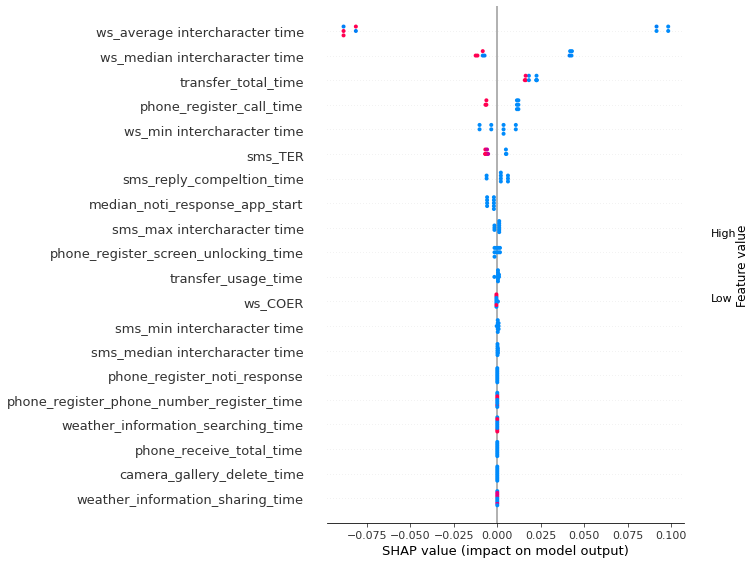

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list[0], shap_values_df)

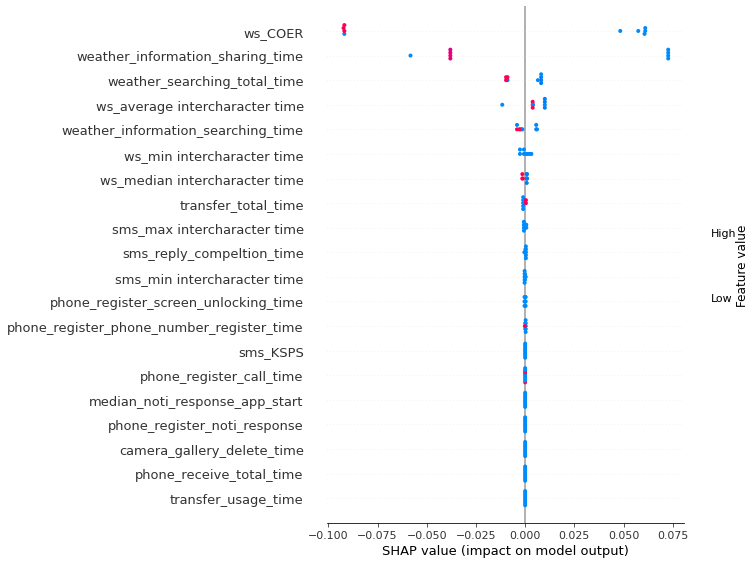

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list[1], shap_values_df)

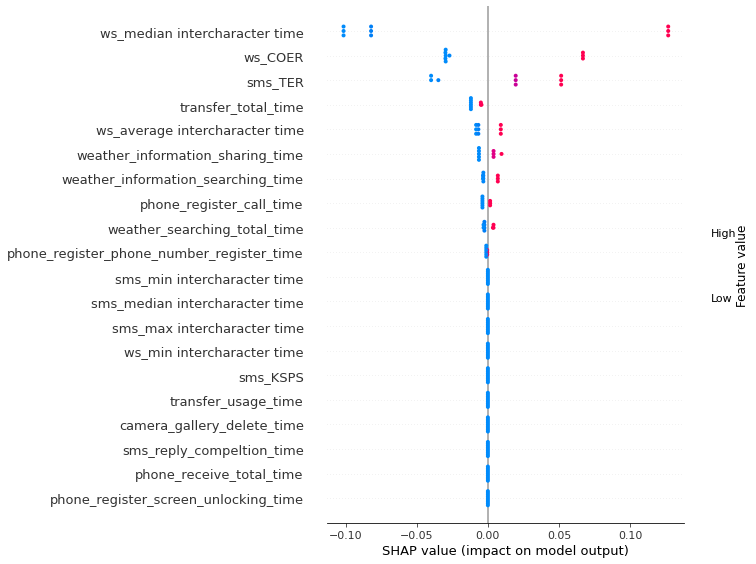

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list[2], shap_values_df)

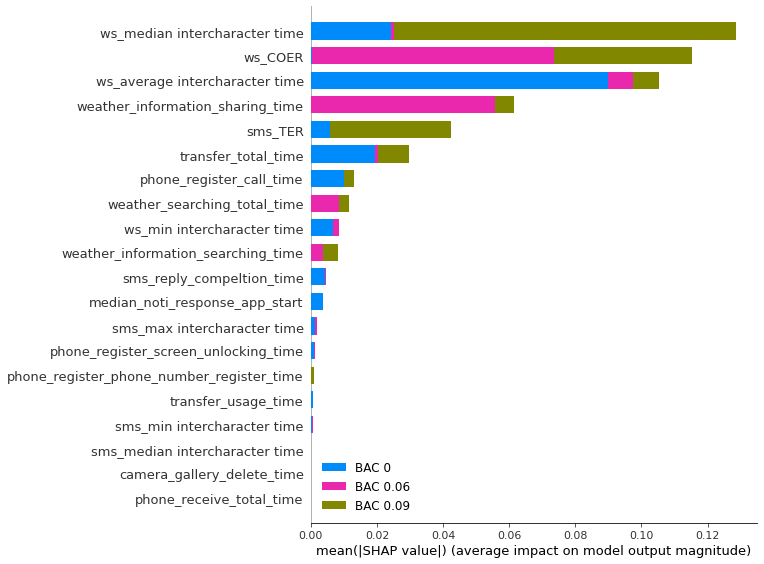

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list, shap_values_df, class_names=['BAC 0', 'BAC 0.06', 'BAC 0.09'], class_inds=[0, 1, 2])

## 2 Labels

In [ ]:
if label_name != 'three_label':
    shap_values_list = []

    for i in range(2):
        shap_values_df = pd.concat(shap_df_list[i], ignore_index=True)
        shap_values_df = shap_values_df.loc[9*best_idx:9*best_idx+8]
        shap_values_df = shap_values_df.dropna(axis=1)
        shap_values = shap_values_df.values
        shap_values_list.append(shap_values)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values_list[0], shap_values_df)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values_list[1], shap_values_df)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values_list, shap_values_df, class_names=['BAC 0', 'BAC 0.09'], class_inds=[0, 1])

# Xgboost Bayesian

In [ ]:
class XBGObjective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial: Trial):    
        xgb_params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0, step=0.1),
            'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 5.0), # lambda_l1
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0), # lambda_l2
            'random_state': 42
        }

        clf = XGBClassifier(**xgb_params)

        mean_accuracy = InnerCrossValidation(clf, self.X, self.y, cv_method, n_fold)

        return mean_accuracy

In [ ]:
clf = XGBClassifier(random_state=42)
shap_df_list, metric_df, best_idx = NestedCVwithOptuna(XBGObjective, clf, 'xgboost')

class_nums :  3


[I 2022-09-02 00:33:22,129] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:33:23,213] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 57, 'learning_rate': 0.0007070768038251008, 'max_depth': 3, 'min_child_weight': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'gamma': 0.9, 'reg_alpha': 3.879654267282017, 'reg_lambda': 2.377748657696452}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 57, 'learning_rate': 0.0007070768038251008, 'max_depth': 3, 'min_child_weight': 6, 'colsample_bytree': 0.5, 'subsample': 0.7, 'gamma': 0.9, 'reg_alpha': 3.879654267282017, 'reg_lambda': 2.377748657696452}
Selected features Num:  20
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_KSPS', 'sms_COER', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  1.0


[I 2022-09-02 00:33:42,682] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:33:48,504] Trial 0 finished with value: 0.5498575498575499 and parameters: {'n_estimators': 480, 'learning_rate': 0.011620858570789752, 'max_depth': 3, 'min_child_weight': 3, 'colsample_bytree': 0.9, 'subsample': 0.7, 'gamma': 4.4, 'reg_alpha': 2.3788742039008324, 'reg_lambda': 1.9248222611599601}. Best is trial 0 with value: 0.5498575498575499.


Optuna Best score :  0.5498575498575499
Best parameters :  {'n_estimators': 480, 'learning_rate': 0.011620858570789752, 'max_depth': 3, 'min_child_weight': 3, 'colsample_bytree': 0.9, 'subsample': 0.7, 'gamma': 4.4, 'reg_alpha': 2.3788742039008324, 'reg_lambda': 1.9248222611599601}
Selected features Num:  35
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacte

[I 2022-09-02 00:34:08,217] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:34:11,628] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 292, 'learning_rate': 0.02764659540501248, 'max_depth': 4, 'min_child_weight': 5, 'colsample_bytree': 0.9, 'subsample': 0.8, 'gamma': 0.2, 'reg_alpha': 2.2775508896908243, 'reg_lambda': 3.3539626538166987}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 292, 'learning_rate': 0.02764659540501248, 'max_depth': 4, 'min_child_weight': 5, 'colsample_bytree': 0.9, 'subsample': 0.8, 'gamma': 0.2, 'reg_alpha': 2.2775508896908243, 'reg_lambda': 3.3539626538166987}
Selected features Num:  20
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'phone_register_screen_unlocking_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_median intercharacter time', 'sms_COER', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  1.0


[I 2022-09-02 00:34:30,885] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:34:33,982] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 349, 'learning_rate': 0.001847872649578179, 'max_depth': 4, 'min_child_weight': 9, 'colsample_bytree': 0.6, 'subsample': 0.5, 'gamma': 0.30000000000000004, 'reg_alpha': 4.135932109938423, 'reg_lambda': 3.993842185917756}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 349, 'learning_rate': 0.001847872649578179, 'max_depth': 4, 'min_child_weight': 9, 'colsample_bytree': 0.6, 'subsample': 0.5, 'gamma': 0.30000000000000004, 'reg_alpha': 4.135932109938423, 'reg_lambda': 3.993842185917756}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'sms_UB', '

[I 2022-09-02 00:34:52,880] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:34:58,212] Trial 0 finished with value: 0.5584045584045584 and parameters: {'n_estimators': 391, 'learning_rate': 0.051354138895634435, 'max_depth': 4, 'min_child_weight': 7, 'colsample_bytree': 1.0, 'subsample': 0.6, 'gamma': 3.2, 'reg_alpha': 3.001722617465946, 'reg_lambda': 2.8947326907369453}. Best is trial 0 with value: 0.5584045584045584.


Optuna Best score :  0.5584045584045584
Best parameters :  {'n_estimators': 391, 'learning_rate': 0.051354138895634435, 'max_depth': 4, 'min_child_weight': 7, 'colsample_bytree': 1.0, 'subsample': 0.6, 'gamma': 3.2, 'reg_alpha': 3.001722617465946, 'reg_lambda': 2.8947326907369453}
Selected features Num:  38
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_

[I 2022-09-02 00:35:17,274] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:35:24,062] Trial 0 finished with value: 0.5498575498575499 and parameters: {'n_estimators': 424, 'learning_rate': 0.0006946758307575781, 'max_depth': 6, 'min_child_weight': 5, 'colsample_bytree': 0.7, 'subsample': 0.7, 'gamma': 0.8, 'reg_alpha': 3.0141309155630283, 'reg_lambda': 1.8595404359289032}. Best is trial 0 with value: 0.5498575498575499.


Optuna Best score :  0.5498575498575499
Best parameters :  {'n_estimators': 424, 'learning_rate': 0.0006946758307575781, 'max_depth': 6, 'min_child_weight': 5, 'colsample_bytree': 0.7, 'subsample': 0.7, 'gamma': 0.8, 'reg_alpha': 3.0141309155630283, 'reg_lambda': 1.8595404359289032}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_

[I 2022-09-02 00:35:43,485] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:35:46,487] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 239, 'learning_rate': 0.00010887490549920294, 'max_depth': 8, 'min_child_weight': 9, 'colsample_bytree': 0.5, 'subsample': 0.8, 'gamma': 0.5, 'reg_alpha': 1.9258048760288866, 'reg_lambda': 4.465606989657919}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 239, 'learning_rate': 0.00010887490549920294, 'max_depth': 8, 'min_child_weight': 9, 'colsample_bytree': 0.5, 'subsample': 0.8, 'gamma': 0.5, 'reg_alpha': 1.9258048760288866, 'reg_lambda': 4.465606989657919}
Selected features Num:  35
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Camera', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter 

[I 2022-09-02 00:36:05,754] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:36:09,304] Trial 0 finished with value: 0.5470085470085471 and parameters: {'n_estimators': 263, 'learning_rate': 0.004794554585177894, 'max_depth': 7, 'min_child_weight': 6, 'colsample_bytree': 0.5, 'subsample': 0.8, 'gamma': 4.9, 'reg_alpha': 3.7747261675626036, 'reg_lambda': 4.733978265792897}. Best is trial 0 with value: 0.5470085470085471.


Optuna Best score :  0.5470085470085471
Best parameters :  {'n_estimators': 263, 'learning_rate': 0.004794554585177894, 'max_depth': 7, 'min_child_weight': 6, 'colsample_bytree': 0.5, 'subsample': 0.8, 'gamma': 4.9, 'reg_alpha': 3.7747261675626036, 'reg_lambda': 4.733978265792897}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_COER', 'sms_TER', 'ws_average intercharacter t

[I 2022-09-02 00:36:28,989] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:36:31,079] Trial 0 finished with value: 0.5042735042735043 and parameters: {'n_estimators': 117, 'learning_rate': 0.00018631769789197083, 'max_depth': 7, 'min_child_weight': 3, 'colsample_bytree': 0.8, 'subsample': 1.0, 'gamma': 1.3, 'reg_alpha': 3.7994767816287855, 'reg_lambda': 4.0892111309936645}. Best is trial 0 with value: 0.5042735042735043.


Optuna Best score :  0.5042735042735043
Best parameters :  {'n_estimators': 117, 'learning_rate': 0.00018631769789197083, 'max_depth': 7, 'min_child_weight': 3, 'colsample_bytree': 0.8, 'subsample': 1.0, 'gamma': 1.3, 'reg_alpha': 3.7994767816287855, 'reg_lambda': 4.0892111309936645}
Selected features Num:  20
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_COER', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.7777777777777778


[I 2022-09-02 00:36:50,412] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:36:57,384] Trial 0 finished with value: 0.5441595441595442 and parameters: {'n_estimators': 475, 'learning_rate': 0.0048022893854888105, 'max_depth': 8, 'min_child_weight': 5, 'colsample_bytree': 1.0, 'subsample': 0.8, 'gamma': 4.800000000000001, 'reg_alpha': 3.538341260127095, 'reg_lambda': 3.1195897363340275}. Best is trial 0 with value: 0.5441595441595442.


Optuna Best score :  0.5441595441595442
Best parameters :  {'n_estimators': 475, 'learning_rate': 0.0048022893854888105, 'max_depth': 8, 'min_child_weight': 5, 'colsample_bytree': 1.0, 'subsample': 0.8, 'gamma': 4.800000000000001, 'reg_alpha': 3.538341260127095, 'reg_lambda': 3.1195897363340275}
Selected features Num:  20
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.5555555555555556


[I 2022-09-02 00:37:17,373] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:37:19,047] Trial 0 finished with value: 0.5726495726495726 and parameters: {'n_estimators': 162, 'learning_rate': 0.003467023251833393, 'max_depth': 3, 'min_child_weight': 8, 'colsample_bytree': 0.8, 'subsample': 1.0, 'gamma': 1.2000000000000002, 'reg_alpha': 2.986639498561987, 'reg_lambda': 2.0346243110599103}. Best is trial 0 with value: 0.5726495726495726.


Optuna Best score :  0.5726495726495726
Best parameters :  {'n_estimators': 162, 'learning_rate': 0.003467023251833393, 'max_depth': 3, 'min_child_weight': 8, 'colsample_bytree': 0.8, 'subsample': 1.0, 'gamma': 1.2000000000000002, 'reg_alpha': 2.986639498561987, 'reg_lambda': 2.0346243110599103}
Selected features Num:  20
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_median intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.5555555555555556


[I 2022-09-02 00:37:37,503] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:37:42,469] Trial 0 finished with value: 0.5470085470085471 and parameters: {'n_estimators': 251, 'learning_rate': 0.0010178604009292496, 'max_depth': 8, 'min_child_weight': 2, 'colsample_bytree': 1.0, 'subsample': 0.5, 'gamma': 0.30000000000000004, 'reg_alpha': 3.4319826048026782, 'reg_lambda': 4.976629906953594}. Best is trial 0 with value: 0.5470085470085471.


Optuna Best score :  0.5470085470085471
Best parameters :  {'n_estimators': 251, 'learning_rate': 0.0010178604009292496, 'max_depth': 8, 'min_child_weight': 2, 'colsample_bytree': 1.0, 'subsample': 0.5, 'gamma': 0.30000000000000004, 'reg_alpha': 3.4319826048026782, 'reg_lambda': 4.976629906953594}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Camera', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'we

[I 2022-09-02 00:38:01,566] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:38:07,655] Trial 0 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 467, 'learning_rate': 0.05748313143544859, 'max_depth': 4, 'min_child_weight': 2, 'colsample_bytree': 1.0, 'subsample': 0.5, 'gamma': 0.5, 'reg_alpha': 4.711012008344245, 'reg_lambda': 3.8698703130832546}. Best is trial 0 with value: 0.5811965811965812.


Optuna Best score :  0.5811965811965812
Best parameters :  {'n_estimators': 467, 'learning_rate': 0.05748313143544859, 'max_depth': 4, 'min_child_weight': 2, 'colsample_bytree': 1.0, 'subsample': 0.5, 'gamma': 0.5, 'reg_alpha': 4.711012008344245, 'reg_lambda': 3.8698703130832546}
Selected features Num:  32
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_1', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sm

[I 2022-09-02 00:38:26,462] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:38:27,142] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 61, 'learning_rate': 0.0069831612263837805, 'max_depth': 10, 'min_child_weight': 9, 'colsample_bytree': 0.5, 'subsample': 0.5, 'gamma': 0.1, 'reg_alpha': 4.639704373426586, 'reg_lambda': 2.8676445420333487}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 61, 'learning_rate': 0.0069831612263837805, 'max_depth': 10, 'min_child_weight': 9, 'colsample_bytree': 0.5, 'subsample': 0.5, 'gamma': 0.1, 'reg_alpha': 4.639704373426586, 'reg_lambda': 2.8676445420333487}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_in

[I 2022-09-02 00:38:48,345] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:38:51,662] Trial 0 finished with value: 0.5897435897435898 and parameters: {'n_estimators': 321, 'learning_rate': 0.00022016906556011933, 'max_depth': 9, 'min_child_weight': 7, 'colsample_bytree': 0.5, 'subsample': 0.5, 'gamma': 0.5, 'reg_alpha': 1.0875387698527126, 'reg_lambda': 1.1360169448218906}. Best is trial 0 with value: 0.5897435897435898.


Optuna Best score :  0.5897435897435898
Best parameters :  {'n_estimators': 321, 'learning_rate': 0.00022016906556011933, 'max_depth': 9, 'min_child_weight': 7, 'colsample_bytree': 0.5, 'subsample': 0.5, 'gamma': 0.5, 'reg_alpha': 1.0875387698527126, 'reg_lambda': 1.1360169448218906}
Selected features Num:  26
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'ws_average intercharacter time', 'ws_median

[I 2022-09-02 00:39:10,395] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:39:14,617] Trial 0 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 275, 'learning_rate': 0.002137598730233808, 'max_depth': 6, 'min_child_weight': 8, 'colsample_bytree': 0.8, 'subsample': 0.8, 'gamma': 0.4, 'reg_alpha': 3.2557112639573993, 'reg_lambda': 3.1850152593685155}. Best is trial 0 with value: 0.5811965811965812.


Optuna Best score :  0.5811965811965812
Best parameters :  {'n_estimators': 275, 'learning_rate': 0.002137598730233808, 'max_depth': 6, 'min_child_weight': 8, 'colsample_bytree': 0.8, 'subsample': 0.8, 'gamma': 0.4, 'reg_alpha': 3.2557112639573993, 'reg_lambda': 3.1850152593685155}
Selected features Num:  38
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average interchar

[I 2022-09-02 00:39:33,508] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:39:50,678] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 484, 'learning_rate': 0.002320766646084241, 'max_depth': 4, 'min_child_weight': 1, 'colsample_bytree': 1.0, 'subsample': 0.6, 'gamma': 1.6, 'reg_alpha': 1.1004474339515604, 'reg_lambda': 2.57222327062784}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 484, 'learning_rate': 0.002320766646084241, 'max_depth': 4, 'min_child_weight': 1, 'colsample_bytree': 1.0, 'subsample': 0.6, 'gamma': 1.6, 'reg_alpha': 1.1004474339515604, 'reg_lambda': 2.57222327062784}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'wea

[I 2022-09-02 00:40:11,803] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:40:16,745] Trial 0 finished with value: 0.5555555555555556 and parameters: {'n_estimators': 341, 'learning_rate': 0.004325559060538871, 'max_depth': 5, 'min_child_weight': 3, 'colsample_bytree': 0.7, 'subsample': 0.7, 'gamma': 3.4000000000000004, 'reg_alpha': 4.4477093495074715, 'reg_lambda': 4.445490429133983}. Best is trial 0 with value: 0.5555555555555556.


Optuna Best score :  0.5555555555555556
Best parameters :  {'n_estimators': 341, 'learning_rate': 0.004325559060538871, 'max_depth': 5, 'min_child_weight': 3, 'colsample_bytree': 0.7, 'subsample': 0.7, 'gamma': 3.4000000000000004, 'reg_alpha': 4.4477093495074715, 'reg_lambda': 4.445490429133983}
Selected features Num:  23
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Weather_Searching', 'transition_sum_trial', 'phone_register_noti_response', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.5555555555555556


[I 2022-09-02 00:40:36,555] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:40:40,779] Trial 0 finished with value: 0.5470085470085471 and parameters: {'n_estimators': 340, 'learning_rate': 0.00010992729329840109, 'max_depth': 9, 'min_child_weight': 5, 'colsample_bytree': 0.6, 'subsample': 0.6, 'gamma': 4.6000000000000005, 'reg_alpha': 3.4118233862354987, 'reg_lambda': 2.494872257907006}. Best is trial 0 with value: 0.5470085470085471.


Optuna Best score :  0.5470085470085471
Best parameters :  {'n_estimators': 340, 'learning_rate': 0.00010992729329840109, 'max_depth': 9, 'min_child_weight': 5, 'colsample_bytree': 0.6, 'subsample': 0.6, 'gamma': 4.6000000000000005, 'reg_alpha': 3.4118233862354987, 'reg_lambda': 2.494872257907006}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_max intercharacter time', 'sms_C

[I 2022-09-02 00:41:00,253] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:41:08,999] Trial 0 finished with value: 0.5555555555555556 and parameters: {'n_estimators': 364, 'learning_rate': 0.0005023177003208496, 'max_depth': 9, 'min_child_weight': 1, 'colsample_bytree': 0.6, 'subsample': 1.0, 'gamma': 0.7000000000000001, 'reg_alpha': 1.9359107479147815, 'reg_lambda': 2.707596443806039}. Best is trial 0 with value: 0.5555555555555556.


Optuna Best score :  0.5555555555555556
Best parameters :  {'n_estimators': 364, 'learning_rate': 0.0005023177003208496, 'max_depth': 9, 'min_child_weight': 1, 'colsample_bytree': 0.6, 'subsample': 1.0, 'gamma': 0.7000000000000001, 'reg_alpha': 1.9359107479147815, 'reg_lambda': 2.707596443806039}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_CPS', 'sms_GPS', 'sms_COER

[I 2022-09-02 00:41:29,159] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:41:36,210] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 347, 'learning_rate': 0.00826964546116254, 'max_depth': 6, 'min_child_weight': 3, 'colsample_bytree': 0.9, 'subsample': 0.9, 'gamma': 4.9, 'reg_alpha': 2.8284143543655453, 'reg_lambda': 3.1594592731676783}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 347, 'learning_rate': 0.00826964546116254, 'max_depth': 6, 'min_child_weight': 3, 'colsample_bytree': 0.9, 'subsample': 0.9, 'gamma': 4.9, 'reg_alpha': 2.8284143543655453, 'reg_lambda': 3.1594592731676783}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Camera', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_CPS', 'sms_COER', '

[I 2022-09-02 00:41:55,733] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:41:56,459] Trial 0 finished with value: 0.5270655270655271 and parameters: {'n_estimators': 56, 'learning_rate': 0.0151586982687842, 'max_depth': 5, 'min_child_weight': 6, 'colsample_bytree': 0.8, 'subsample': 0.5, 'gamma': 5.0, 'reg_alpha': 2.951421476523883, 'reg_lambda': 4.080110909235806}. Best is trial 0 with value: 0.5270655270655271.


Optuna Best score :  0.5270655270655271
Best parameters :  {'n_estimators': 56, 'learning_rate': 0.0151586982687842, 'max_depth': 5, 'min_child_weight': 6, 'colsample_bytree': 0.8, 'subsample': 0.5, 'gamma': 5.0, 'reg_alpha': 2.951421476523883, 'reg_lambda': 4.080110909235806}
Selected features Num:  32
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CP

[I 2022-09-02 00:42:14,804] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:42:15,713] Trial 0 finished with value: 0.5327635327635327 and parameters: {'n_estimators': 70, 'learning_rate': 0.03636786682754383, 'max_depth': 6, 'min_child_weight': 8, 'colsample_bytree': 0.9, 'subsample': 0.5, 'gamma': 3.9000000000000004, 'reg_alpha': 2.6085821666311317, 'reg_lambda': 4.163602095037968}. Best is trial 0 with value: 0.5327635327635327.


Optuna Best score :  0.5327635327635327
Best parameters :  {'n_estimators': 70, 'learning_rate': 0.03636786682754383, 'max_depth': 6, 'min_child_weight': 8, 'colsample_bytree': 0.9, 'subsample': 0.5, 'gamma': 3.9000000000000004, 'reg_alpha': 2.6085821666311317, 'reg_lambda': 4.163602095037968}
Selected features Num:  35
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average interc

[I 2022-09-02 00:42:34,488] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:42:39,215] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 351, 'learning_rate': 0.00011031490696817477, 'max_depth': 10, 'min_child_weight': 9, 'colsample_bytree': 0.6, 'subsample': 0.8, 'gamma': 2.2, 'reg_alpha': 2.1746297916111565, 'reg_lambda': 4.614857064409513}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 351, 'learning_rate': 0.00011031490696817477, 'max_depth': 10, 'min_child_weight': 9, 'colsample_bytree': 0.6, 'subsample': 0.8, 'gamma': 2.2, 'reg_alpha': 2.1746297916111565, 'reg_lambda': 4.614857064409513}
Selected features Num:  38
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Camera', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_informa

[I 2022-09-02 00:43:00,678] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:43:08,181] Trial 0 finished with value: 0.5783475783475783 and parameters: {'n_estimators': 325, 'learning_rate': 0.00018454087795865426, 'max_depth': 5, 'min_child_weight': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'gamma': 2.1, 'reg_alpha': 1.8058082567909866, 'reg_lambda': 4.313274631662268}. Best is trial 0 with value: 0.5783475783475783.


Optuna Best score :  0.5783475783475783
Best parameters :  {'n_estimators': 325, 'learning_rate': 0.00018454087795865426, 'max_depth': 5, 'min_child_weight': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'gamma': 2.1, 'reg_alpha': 1.8058082567909866, 'reg_lambda': 4.313274631662268}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Camera', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_to

[I 2022-09-02 00:43:34,987] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:43:37,206] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 180, 'learning_rate': 0.0006116764254753987, 'max_depth': 3, 'min_child_weight': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'gamma': 2.0, 'reg_alpha': 1.9548326174763253, 'reg_lambda': 1.5431938555766957}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 180, 'learning_rate': 0.0006116764254753987, 'max_depth': 3, 'min_child_weight': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'gamma': 2.0, 'reg_alpha': 1.9548326174763253, 'reg_lambda': 1.5431938555766957}
Selected features Num:  26
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Camera', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_CPS', 'sms_COER', 'sms_UER', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test acc

[I 2022-09-02 00:44:00,338] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:44:01,840] Trial 0 finished with value: 0.5897435897435898 and parameters: {'n_estimators': 90, 'learning_rate': 0.08564165342318861, 'max_depth': 3, 'min_child_weight': 1, 'colsample_bytree': 0.5, 'subsample': 0.8, 'gamma': 2.1, 'reg_alpha': 3.68807501406785, 'reg_lambda': 2.044174588394859}. Best is trial 0 with value: 0.5897435897435898.


Optuna Best score :  0.5897435897435898
Best parameters :  {'n_estimators': 90, 'learning_rate': 0.08564165342318861, 'max_depth': 3, 'min_child_weight': 1, 'colsample_bytree': 0.5, 'subsample': 0.8, 'gamma': 2.1, 'reg_alpha': 3.68807501406785, 'reg_lambda': 2.044174588394859}
Selected features Num:  38
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time'

[I 2022-09-02 00:44:24,472] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:44:27,668] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 149, 'learning_rate': 0.0005507242789736057, 'max_depth': 10, 'min_child_weight': 7, 'colsample_bytree': 0.6, 'subsample': 1.0, 'gamma': 1.9000000000000001, 'reg_alpha': 1.3192283385375938, 'reg_lambda': 2.9469792635283776}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 149, 'learning_rate': 0.0005507242789736057, 'max_depth': 10, 'min_child_weight': 7, 'colsample_bytree': 0.6, 'subsample': 1.0, 'gamma': 1.9000000000000001, 'reg_alpha': 1.3192283385375938, 'reg_lambda': 2.9469792635283776}
Selected features Num:  38
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_informa

[I 2022-09-02 00:44:51,645] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:45:00,811] Trial 0 finished with value: 0.584045584045584 and parameters: {'n_estimators': 363, 'learning_rate': 0.09456426466796565, 'max_depth': 8, 'min_child_weight': 2, 'colsample_bytree': 0.8, 'subsample': 0.9, 'gamma': 3.4000000000000004, 'reg_alpha': 2.85084744091017, 'reg_lambda': 4.9612645110820255}. Best is trial 0 with value: 0.584045584045584.


Optuna Best score :  0.584045584045584
Best parameters :  {'n_estimators': 363, 'learning_rate': 0.09456426466796565, 'max_depth': 8, 'min_child_weight': 2, 'colsample_bytree': 0.8, 'subsample': 0.9, 'gamma': 3.4000000000000004, 'reg_alpha': 2.85084744091017, 'reg_lambda': 4.9612645110820255}
Selected features Num:  23
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_COER', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.55555

[I 2022-09-02 00:45:26,378] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:45:29,230] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 186, 'learning_rate': 0.002550227156611577, 'max_depth': 7, 'min_child_weight': 6, 'colsample_bytree': 0.5, 'subsample': 0.6, 'gamma': 2.9000000000000004, 'reg_alpha': 2.03035954273019, 'reg_lambda': 2.029408686517111}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 186, 'learning_rate': 0.002550227156611577, 'max_depth': 7, 'min_child_weight': 6, 'colsample_bytree': 0.5, 'subsample': 0.6, 'gamma': 2.9000000000000004, 'reg_alpha': 2.03035954273019, 'reg_lambda': 2.029408686517111}
Selected features Num:  26
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Receive', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_COER', 'sms_UER', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_CPS', 'ws_KSPS', '

[I 2022-09-02 00:45:54,479] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:45:59,478] Trial 0 finished with value: 0.5470085470085471 and parameters: {'n_estimators': 255, 'learning_rate': 0.07460480575675071, 'max_depth': 7, 'min_child_weight': 9, 'colsample_bytree': 1.0, 'subsample': 0.9, 'gamma': 3.3000000000000003, 'reg_alpha': 1.3094673922181923, 'reg_lambda': 4.5965329055041195}. Best is trial 0 with value: 0.5470085470085471.


Optuna Best score :  0.5470085470085471
Best parameters :  {'n_estimators': 255, 'learning_rate': 0.07460480575675071, 'max_depth': 7, 'min_child_weight': 9, 'colsample_bytree': 1.0, 'subsample': 0.9, 'gamma': 3.3000000000000003, 'reg_alpha': 1.3094673922181923, 'reg_lambda': 4.5965329055041195}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_KSPS', 'sms_COER', 'sms_TER', 'ws_a

[I 2022-09-02 00:46:23,455] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:46:24,659] Trial 0 finished with value: 0.584045584045584 and parameters: {'n_estimators': 64, 'learning_rate': 0.08619965350009991, 'max_depth': 6, 'min_child_weight': 5, 'colsample_bytree': 0.6, 'subsample': 0.7, 'gamma': 0.5, 'reg_alpha': 1.0012050676065951, 'reg_lambda': 1.155045358907132}. Best is trial 0 with value: 0.584045584045584.


Optuna Best score :  0.584045584045584
Best parameters :  {'n_estimators': 64, 'learning_rate': 0.08619965350009991, 'max_depth': 6, 'min_child_weight': 5, 'colsample_bytree': 0.6, 'subsample': 0.7, 'gamma': 0.5, 'reg_alpha': 1.0012050676065951, 'reg_lambda': 1.155045358907132}
Selected features Num:  26
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Camera', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']

[I 2022-09-02 00:46:48,019] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:46:59,449] Trial 0 finished with value: 0.5327635327635327 and parameters: {'n_estimators': 472, 'learning_rate': 0.0014028034147068325, 'max_depth': 10, 'min_child_weight': 1, 'colsample_bytree': 0.7, 'subsample': 0.6, 'gamma': 2.4000000000000004, 'reg_alpha': 3.8212850944439305, 'reg_lambda': 2.2513356832731213}. Best is trial 0 with value: 0.5327635327635327.


Optuna Best score :  0.5327635327635327
Best parameters :  {'n_estimators': 472, 'learning_rate': 0.0014028034147068325, 'max_depth': 10, 'min_child_weight': 1, 'colsample_bytree': 0.7, 'subsample': 0.6, 'gamma': 2.4000000000000004, 'reg_alpha': 3.8212850944439305, 'reg_lambda': 2.2513356832731213}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_CPS', 'sms_COER

[I 2022-09-02 00:47:24,062] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:47:29,193] Trial 0 finished with value: 0.5783475783475783 and parameters: {'n_estimators': 359, 'learning_rate': 0.0007121297767789556, 'max_depth': 4, 'min_child_weight': 9, 'colsample_bytree': 0.7, 'subsample': 0.7, 'gamma': 2.2, 'reg_alpha': 1.2211996172668331, 'reg_lambda': 2.84279448131483}. Best is trial 0 with value: 0.5783475783475783.


Optuna Best score :  0.5783475783475783
Best parameters :  {'n_estimators': 359, 'learning_rate': 0.0007121297767789556, 'max_depth': 4, 'min_child_weight': 9, 'colsample_bytree': 0.7, 'subsample': 0.7, 'gamma': 2.2, 'reg_alpha': 1.2211996172668331, 'reg_lambda': 2.84279448131483}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_COER', 'ws_averag

[I 2022-09-02 00:47:53,594] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:47:57,687] Trial 0 finished with value: 0.5726495726495726 and parameters: {'n_estimators': 175, 'learning_rate': 0.0005321795024846674, 'max_depth': 10, 'min_child_weight': 2, 'colsample_bytree': 0.6, 'subsample': 0.8, 'gamma': 4.5, 'reg_alpha': 2.8727986177517932, 'reg_lambda': 2.02682377090466}. Best is trial 0 with value: 0.5726495726495726.


Optuna Best score :  0.5726495726495726
Best parameters :  {'n_estimators': 175, 'learning_rate': 0.0005321795024846674, 'max_depth': 10, 'min_child_weight': 2, 'colsample_bytree': 0.6, 'subsample': 0.8, 'gamma': 4.5, 'reg_alpha': 2.8727986177517932, 'reg_lambda': 2.02682377090466}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_GPS', 'sms_COER', 'sms_TER', '

[I 2022-09-02 00:48:22,309] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:48:27,751] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 452, 'learning_rate': 0.03669012820145908, 'max_depth': 3, 'min_child_weight': 7, 'colsample_bytree': 0.6, 'subsample': 1.0, 'gamma': 3.9000000000000004, 'reg_alpha': 4.503985348781974, 'reg_lambda': 2.9221198687704577}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 452, 'learning_rate': 0.03669012820145908, 'max_depth': 3, 'min_child_weight': 7, 'colsample_bytree': 0.6, 'subsample': 1.0, 'gamma': 3.9000000000000004, 'reg_alpha': 4.503985348781974, 'reg_lambda': 2.9221198687704577}
Selected features Num:  20
Selected features :  ['Transition_Weather_Searching', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'sms_reply_compeltion_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.2222222222222222


[I 2022-09-02 00:48:52,463] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:48:59,072] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 418, 'learning_rate': 0.00757413705232629, 'max_depth': 9, 'min_child_weight': 7, 'colsample_bytree': 0.6, 'subsample': 0.6, 'gamma': 3.3000000000000003, 'reg_alpha': 1.5894815365463604, 'reg_lambda': 2.3289891695466047}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 418, 'learning_rate': 0.00757413705232629, 'max_depth': 9, 'min_child_weight': 7, 'colsample_bytree': 0.6, 'subsample': 0.6, 'gamma': 3.3000000000000003, 'reg_alpha': 1.5894815365463604, 'reg_lambda': 2.3289891695466047}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_KSPS', 'sms_COER', 'sms_UER', 'sms_TER', 'ws_average intercharacter time', 'ws_

[I 2022-09-02 00:49:24,020] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:49:27,667] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 166, 'learning_rate': 0.022070518177071424, 'max_depth': 9, 'min_child_weight': 2, 'colsample_bytree': 0.8, 'subsample': 0.5, 'gamma': 1.4000000000000001, 'reg_alpha': 2.584131522576214, 'reg_lambda': 3.566606206034412}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 166, 'learning_rate': 0.022070518177071424, 'max_depth': 9, 'min_child_weight': 2, 'colsample_bytree': 0.8, 'subsample': 0.5, 'gamma': 1.4000000000000001, 'reg_alpha': 2.584131522576214, 'reg_lambda': 3.566606206034412}
Selected features Num:  26
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'ws_average intercharacter time', 'ws_

[I 2022-09-02 00:49:53,159] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:50:03,439] Trial 0 finished with value: 0.5384615384615384 and parameters: {'n_estimators': 473, 'learning_rate': 0.04621515207357355, 'max_depth': 8, 'min_child_weight': 9, 'colsample_bytree': 0.7, 'subsample': 1.0, 'gamma': 3.5, 'reg_alpha': 2.938737602504407, 'reg_lambda': 3.962016736505381}. Best is trial 0 with value: 0.5384615384615384.


Optuna Best score :  0.5384615384615384
Best parameters :  {'n_estimators': 473, 'learning_rate': 0.04621515207357355, 'max_depth': 8, 'min_child_weight': 9, 'colsample_bytree': 0.7, 'subsample': 1.0, 'gamma': 3.5, 'reg_alpha': 2.938737602504407, 'reg_lambda': 3.962016736505381}
Selected features Num:  35
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_average intercharacter time', 'sms_median intercharacte

[I 2022-09-02 00:50:31,834] A new study created in memory with name: xgboost Study
[I 2022-09-02 00:50:39,139] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 329, 'learning_rate': 0.007672283714979565, 'max_depth': 10, 'min_child_weight': 8, 'colsample_bytree': 0.9, 'subsample': 1.0, 'gamma': 3.2, 'reg_alpha': 3.8104904333810743, 'reg_lambda': 4.347529878960813}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 329, 'learning_rate': 0.007672283714979565, 'max_depth': 10, 'min_child_weight': 8, 'colsample_bytree': 0.9, 'subsample': 1.0, 'gamma': 3.2, 'reg_alpha': 3.8104904333810743, 'reg_lambda': 4.347529878960813}
Selected features Num:  20
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'sms_reply_compeltion_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.4444444444444444

mean accuracy :  0.5833333333333333
mean precision :  0.5833333333333333
mean recall :  0.5833333333333333
mean

# Best Model의 Shap 시각화

## 3 Labels

In [ ]:
if label_name == 'three_label':
    shap_values_list = []

    for i in range(3):
        shap_values_df = pd.concat(shap_df_list[i], ignore_index=True)
        shap_values_df = shap_values_df.loc[9*best_idx:9*best_idx+8]
        shap_values_df = shap_values_df.dropna(axis=1)
        shap_values = shap_values_df.values
        shap_values_list.append(shap_values)

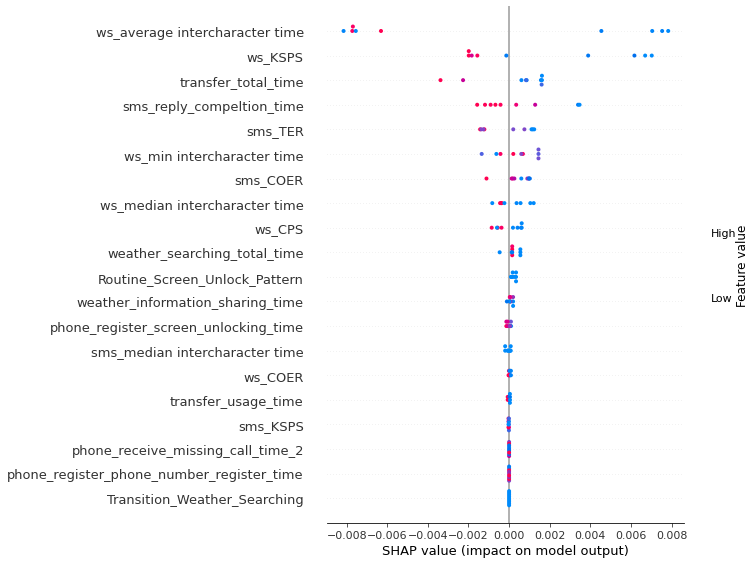

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list[0], shap_values_df)

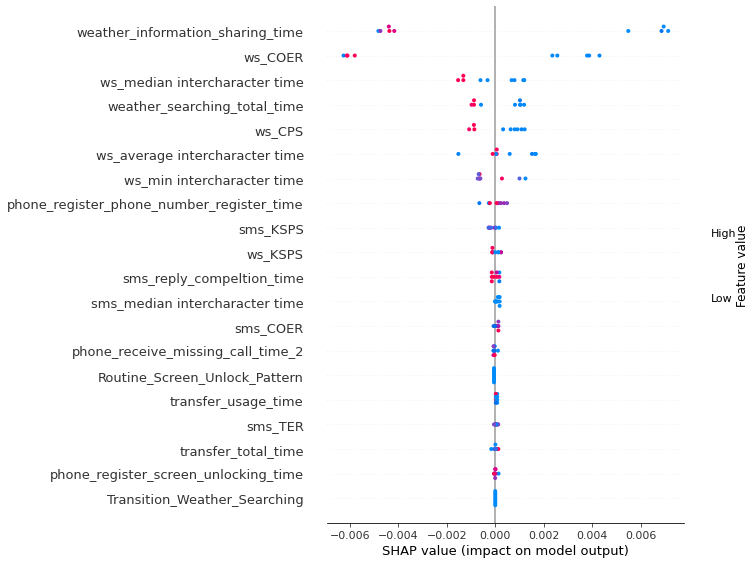

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list[1], shap_values_df)

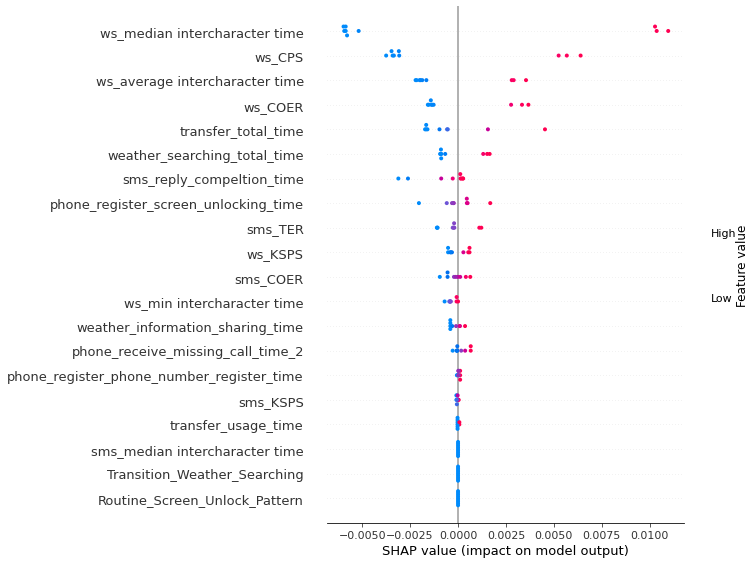

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list[2], shap_values_df)

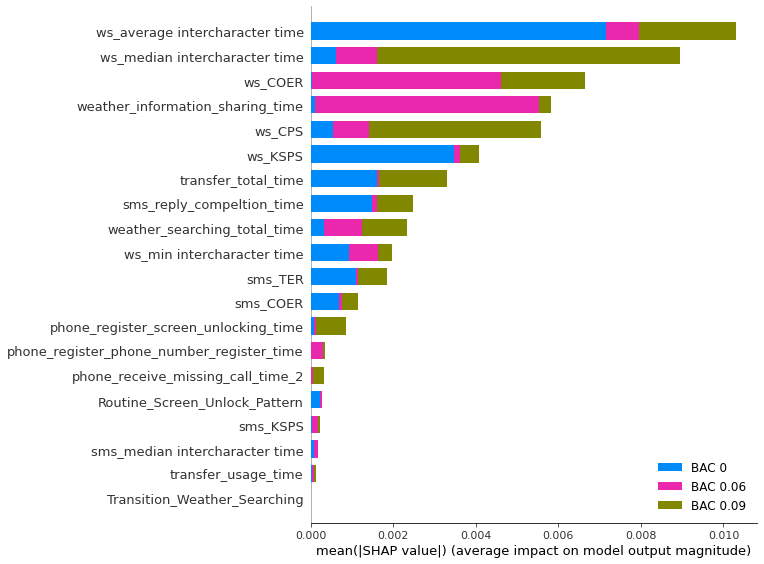

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list, shap_values_df, class_names=['BAC 0', 'BAC 0.06', 'BAC 0.09'], class_inds=[0, 1, 2])

## 2 Labels

In [ ]:
if label_name != 'three_label':
    shap_values_df = pd.concat(shap_df_list[0], ignore_index=True)
    shap_values_df = shap_values_df.loc[9*best_idx:9*best_idx+8]
    shap_values_df = shap_values_df.dropna(axis=1)
    shap_values = shap_values_df.values
    shap_values_list.append(shap_values)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values, shap_values_df)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values, shap_values_df, plot_type='bar')

## 40개의 모델의 개별 performance metric + 평균 performnace metric을 저장한다
## 각 모델별 test set의 feature에 따른 shap value를 저장한다

In [ ]:
if label_name == 'three_label':
    shap_values_df_0 = pd.concat(shap_df_list[0])
    shap_values_df_1 = pd.concat(shap_df_list[1])
    shap_values_df_2 = pd.concat(shap_df_list[2])

    with pd.ExcelWriter(f"./xgb_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df_0.to_excel(writer, sheet_name="shap_list_0", index=False)
        shap_values_df_1.to_excel(writer, sheet_name="shap_list_1", index=False)
        shap_values_df_2.to_excel(writer, sheet_name="shap_list_2", index=False)

if label_name != 'three_label':
    shap_values_df = pd.concat(shap_df_list[0])

    with pd.ExcelWriter(f"./xgb_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)

# Random Forest Bayesian

In [ ]:
class RFObjective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __call__(self, trial: Trial):
        rf_params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'random_state': 42
        }

        clf = RandomForestClassifier(**rf_params)

        mean_accuracy = InnerCrossValidation(clf, self.X, self.y, cv_method, n_fold)

        return mean_accuracy

In [ ]:
clf = RandomForestClassifier(random_state=42)
shap_df_list, metric_df, best_idx = NestedCVwithOptuna(RFObjective, clf, 'randomforest')

class_nums :  3


[I 2022-09-02 00:50:54,984] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:50:55,590] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 63, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 7}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 63, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 7}
Selected features Num:  35
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_TER', 'sms_UB', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'w

[I 2022-09-02 00:51:08,449] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:51:11,950] Trial 0 finished with value: 0.5413105413105413 and parameters: {'n_estimators': 390, 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}. Best is trial 0 with value: 0.5413105413105413.


Optuna Best score :  0.5413105413105413
Best parameters :  {'n_estimators': 390, 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
Selected features Num:  32
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter ti

[I 2022-09-02 00:51:25,208] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:51:28,433] Trial 0 finished with value: 0.5327635327635327 and parameters: {'n_estimators': 324, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7}. Best is trial 0 with value: 0.5327635327635327.


Optuna Best score :  0.5327635327635327
Best parameters :  {'n_estimators': 324, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7}
Selected features Num:  32
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_K

[I 2022-09-02 00:51:41,685] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:51:45,321] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 426, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 4}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 426, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 4}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  1.0


[I 2022-09-02 00:51:58,782] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:52:00,546] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 204, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 5}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 204, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 5}
Selected features Num:  20
Selected features :  ['median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'sms_reply_compeltion_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_UB', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS']
test accuracy :  1.0


[I 2022-09-02 00:52:13,646] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:52:14,770] Trial 0 finished with value: 0.5384615384615384 and parameters: {'n_estimators': 122, 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 3}. Best is trial 0 with value: 0.5384615384615384.


Optuna Best score :  0.5384615384615384
Best parameters :  {'n_estimators': 122, 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 3}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  1.0


[I 2022-09-02 00:52:28,078] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:52:32,024] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 453, 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 7}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 453, 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 7}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS']
test accuracy :  1.0


[I 2022-09-02 00:52:45,384] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:52:45,814] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 53, 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 3}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 53, 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 3}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.7777777777777778


[I 2022-09-02 00:52:58,391] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:53:02,416] Trial 0 finished with value: 0.5299145299145299 and parameters: {'n_estimators': 463, 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 9}. Best is trial 0 with value: 0.5299145299145299.


Optuna Best score :  0.5299145299145299
Best parameters :  {'n_estimators': 463, 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 9}
Selected features Num:  38
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'sms_UB', 'sms_WB', 'ws_average 

[I 2022-09-02 00:53:15,406] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:53:18,479] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 318, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 318, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_COER', 'sms_TER', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  0.5555555555555556


[I 2022-09-02 00:53:30,962] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:53:32,810] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 197, 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 197, 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
Selected features Num:  41
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_GPS

[I 2022-09-02 00:53:45,510] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:53:46,714] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 132, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 132, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  0.4444444444444444


[I 2022-09-02 00:53:59,340] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:54:01,198] Trial 0 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 201, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3}. Best is trial 0 with value: 0.5925925925925926.


Optuna Best score :  0.5925925925925926
Best parameters :  {'n_estimators': 201, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_UB', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  0.3333333333333333


[I 2022-09-02 00:54:13,986] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:54:17,147] Trial 0 finished with value: 0.5897435897435898 and parameters: {'n_estimators': 340, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 10}. Best is trial 0 with value: 0.5897435897435898.


Optuna Best score :  0.5897435897435898
Best parameters :  {'n_estimators': 340, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 10}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB', 'ws_WB']
test accuracy :  0.4444444444444444


[I 2022-09-02 00:54:30,075] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:54:33,494] Trial 0 finished with value: 0.584045584045584 and parameters: {'n_estimators': 385, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 8}. Best is trial 0 with value: 0.584045584045584.


Optuna Best score :  0.584045584045584
Best parameters :  {'n_estimators': 385, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 8}
Selected features Num:  23
Selected features :  ['median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS']
test accuracy :  0.6666666666666666


[I 2022-09-02 00:54:46,444] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:54:48,560] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 282, 'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 10}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 282, 'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 10}
Selected features Num:  23
Selected features :  ['median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS']
test accuracy :  0.4444444444444444


[I 2022-09-02 00:55:00,741] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:55:02,790] Trial 0 finished with value: 0.5584045584045584 and parameters: {'n_estimators': 243, 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 2}. Best is trial 0 with value: 0.5584045584045584.


Optuna Best score :  0.5584045584045584
Best parameters :  {'n_estimators': 243, 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 2}
Selected features Num:  47
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Camera', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time

[I 2022-09-02 00:55:14,937] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:55:18,358] Trial 0 finished with value: 0.5470085470085471 and parameters: {'n_estimators': 354, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}. Best is trial 0 with value: 0.5470085470085471.


Optuna Best score :  0.5470085470085471
Best parameters :  {'n_estimators': 354, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Selected features Num:  47
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter

[I 2022-09-02 00:55:31,437] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:55:35,362] Trial 0 finished with value: 0.5868945868945868 and parameters: {'n_estimators': 466, 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 8}. Best is trial 0 with value: 0.5868945868945868.


Optuna Best score :  0.5868945868945868
Best parameters :  {'n_estimators': 466, 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 8}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB']
test accuracy :  0.5555555555555556


[I 2022-09-02 00:55:48,492] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:55:50,153] Trial 0 finished with value: 0.5783475783475783 and parameters: {'n_estimators': 192, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}. Best is trial 0 with value: 0.5783475783475783.


Optuna Best score :  0.5783475783475783
Best parameters :  {'n_estimators': 192, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'sms_reply_compeltion_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB']
test accuracy :  0.4444444444444444


[I 2022-09-02 00:56:02,285] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:56:03,033] Trial 0 finished with value: 0.5584045584045584 and parameters: {'n_estimators': 79, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 8}. Best is trial 0 with value: 0.5584045584045584.


Optuna Best score :  0.5584045584045584
Best parameters :  {'n_estimators': 79, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 8}
Selected features Num:  47
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Camera', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time'

[I 2022-09-02 00:56:15,715] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:56:18,896] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 382, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 3}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 382, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 3}
Selected features Num:  23
Selected features :  ['median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_WB']
test accuracy :  0.4444444444444444


[I 2022-09-02 00:56:31,768] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:56:32,484] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 83, 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 7}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 83, 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 7}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_UB', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  0.3333333333333333


[I 2022-09-02 00:56:44,575] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:56:48,772] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 472, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 472, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_

[I 2022-09-02 00:57:01,164] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:57:04,943] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 413, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 413, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms

[I 2022-09-02 00:57:17,134] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:57:18,924] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 168, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 3}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 168, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 3}
Selected features Num:  50
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_informa

[I 2022-09-02 00:57:31,648] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:57:33,908] Trial 0 finished with value: 0.5726495726495726 and parameters: {'n_estimators': 257, 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 2}. Best is trial 0 with value: 0.5726495726495726.


Optuna Best score :  0.5726495726495726
Best parameters :  {'n_estimators': 257, 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 2}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.3333333333333333


[I 2022-09-02 00:57:46,238] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:57:47,160] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 7}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 100, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 7}
Selected features Num:  41
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_GP

[I 2022-09-02 00:57:59,907] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:58:03,512] Trial 0 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 411, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 6}. Best is trial 0 with value: 0.5811965811965812.


Optuna Best score :  0.5811965811965812
Best parameters :  {'n_estimators': 411, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 6}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.4444444444444444


[I 2022-09-02 00:58:16,132] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:58:20,209] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 494, 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 4}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 494, 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 4}
Selected features Num:  35
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'sms_UB', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time'

[I 2022-09-02 00:58:33,773] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:58:35,852] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 273, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 7}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 273, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 7}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER']
test accuracy :  0.6666666666666666


[I 2022-09-02 00:58:48,061] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:58:50,427] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 263, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 10}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 263, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 10}
Selected features Num:  47
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Camera', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter tim

[I 2022-09-02 00:59:03,342] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:59:05,627] Trial 0 finished with value: 0.5270655270655271 and parameters: {'n_estimators': 289, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 7}. Best is trial 0 with value: 0.5270655270655271.


Optuna Best score :  0.5270655270655271
Best parameters :  {'n_estimators': 289, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 7}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_WB']
test accuracy :  0.6666666666666666


[I 2022-09-02 00:59:18,049] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:59:19,288] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 134, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 5}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 134, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 5}
Selected features Num:  41
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_GP

[I 2022-09-02 00:59:31,470] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:59:35,393] Trial 0 finished with value: 0.5441595441595442 and parameters: {'n_estimators': 415, 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 6}. Best is trial 0 with value: 0.5441595441595442.


Optuna Best score :  0.5441595441595442
Best parameters :  {'n_estimators': 415, 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 6}
Selected features Num:  47
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Camera', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time

[I 2022-09-02 00:59:47,887] A new study created in memory with name: randomforest Study
[I 2022-09-02 00:59:52,248] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms

[I 2022-09-02 01:00:04,764] A new study created in memory with name: randomforest Study
[I 2022-09-02 01:00:06,512] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 185, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 185, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_

[I 2022-09-02 01:00:19,091] A new study created in memory with name: randomforest Study
[I 2022-09-02 01:00:23,039] Trial 0 finished with value: 0.5783475783475783 and parameters: {'n_estimators': 469, 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 3}. Best is trial 0 with value: 0.5783475783475783.


Optuna Best score :  0.5783475783475783
Best parameters :  {'n_estimators': 469, 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 3}
Selected features Num:  32
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_K

[I 2022-09-02 01:00:35,572] A new study created in memory with name: randomforest Study
[I 2022-09-02 01:00:39,424] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 398, 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 5}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 398, 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 5}
Selected features Num:  47
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Receive', 'Transition_Camera', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time'

[I 2022-09-02 01:00:52,130] A new study created in memory with name: randomforest Study
[I 2022-09-02 01:00:53,789] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 168, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 168, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10}
Selected features Num:  41
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_KSPS', 'sms_GP

# Best Model의 Shap 시각화

## 3 Labels

In [ ]:
if label_name == 'three_label':
    shap_values_list = []

    for i in range(3):
        shap_values_df = pd.concat(shap_df_list[i], ignore_index=True)
        shap_values_df = shap_values_df.loc[9*best_idx:9*best_idx+8]
        shap_values_df = shap_values_df.dropna(axis=1)
        shap_values = shap_values_df.values
        shap_values_list.append(shap_values)

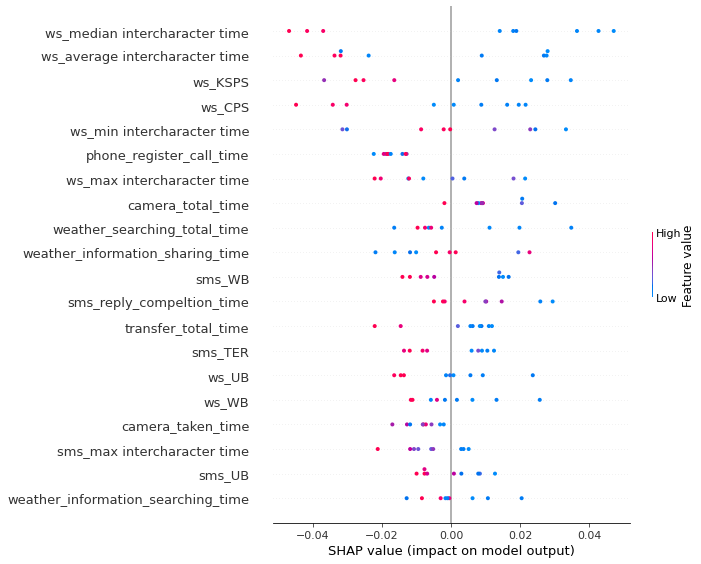

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list[0], shap_values_df)

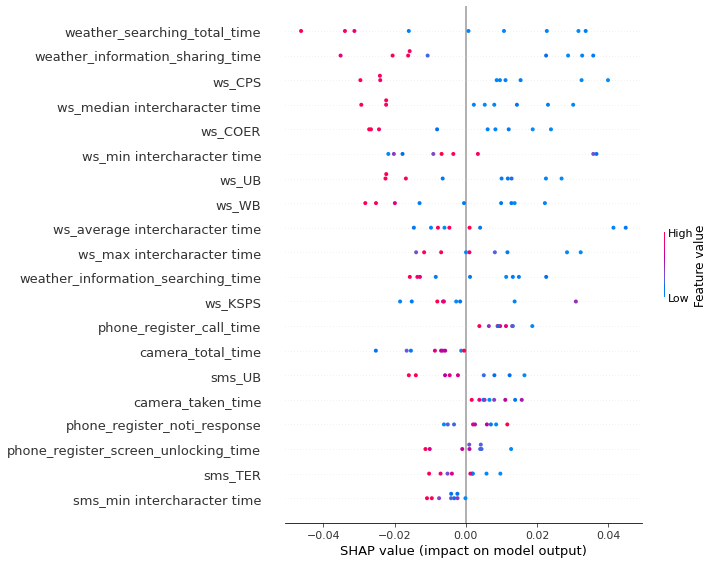

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list[1], shap_values_df)

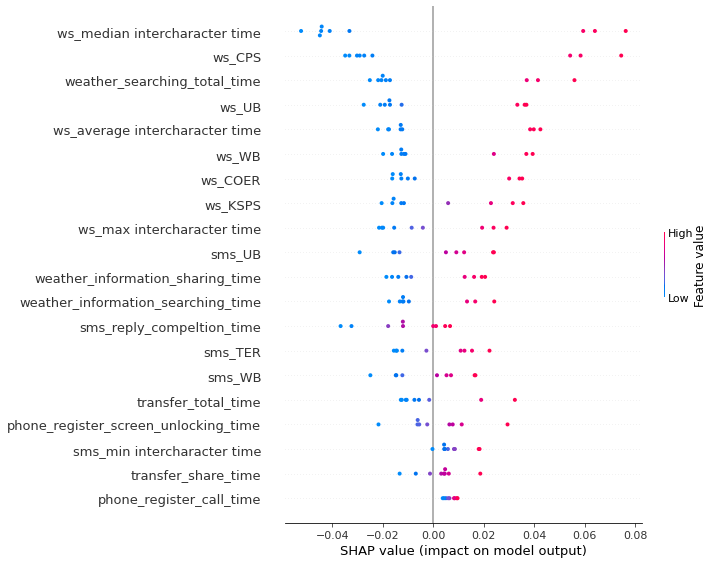

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list[2], shap_values_df)

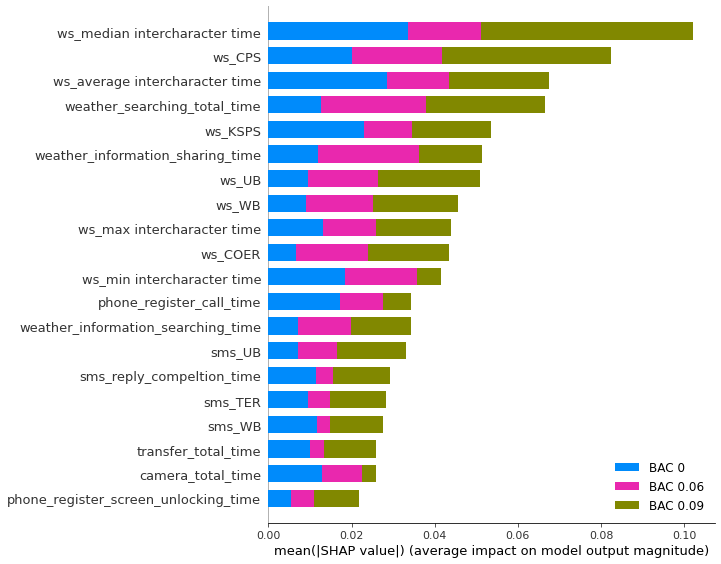

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values_list, shap_values_df, class_names=['BAC 0', 'BAC 0.06', 'BAC 0.09'], class_inds=[0, 1, 2])

## 2 Labels

In [ ]:
if label_name != 'three_label':
    shap_values_list = []

    for i in range(2):
        shap_values_df = pd.concat(shap_df_list[i], ignore_index=True)
        shap_values_df = shap_values_df.loc[9*best_idx:9*best_idx+8]
        shap_values_df = shap_values_df.dropna(axis=1)
        shap_values = shap_values_df.values
        shap_values_list.append(shap_values)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values_list[0], shap_values_df)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values_list[1], shap_values_df)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values_list, shap_values_df, class_names=['BAC 0', 'BAC 0.09'], class_inds=[0, 1])

## 40개의 모델의 개별 performance metric + 평균 performnace metric을 저장한다
## 각 모델별 test set의 feature에 따른 shap value를 저장한다

In [ ]:
if label_name == 'three_label':
    shap_values_df_0 = pd.concat(shap_df_list[0])
    shap_values_df_1 = pd.concat(shap_df_list[1])
    shap_values_df_2 = pd.concat(shap_df_list[2])

    with pd.ExcelWriter(f"./rf_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df_0.to_excel(writer, sheet_name="shap_list_0", index=False)
        shap_values_df_1.to_excel(writer, sheet_name="shap_list_1", index=False)
        shap_values_df_2.to_excel(writer, sheet_name="shap_list_2", index=False)

if label_name != 'three_label':
    shap_values_df = pd.concat(shap_df_list[0])

    with pd.ExcelWriter(f"./rf_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)

# GBM Bayesian

In [ ]:
class GBMObjective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __call__(self, trial: Trial):
        gbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'max_features': trial.suggest_categorical('max_features', [None, 'sqrt']),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1), 
            'random_state': 42
        }

        clf = GradientBoostingClassifier(**gbm_params)

        mean_accuracy = InnerCrossValidation(clf, self.X, self.y, cv_method, n_fold)

        return mean_accuracy

In [ ]:
clf = GradientBoostingClassifier(random_state=42)
shap_df_list, metric_df, best_idx = NestedCVwithOptuna(GBMObjective, clf, 'gbm')

class_nums :  3


[I 2022-09-02 01:13:30,500] A new study created in memory with name: gbm Study
[I 2022-09-02 01:13:35,438] Trial 0 finished with value: 0.5242165242165242 and parameters: {'n_estimators': 248, 'learning_rate': 0.001691603253809976, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 8, 'subsample': 0.6}. Best is trial 0 with value: 0.5242165242165242.


Optuna Best score :  0.5242165242165242
Best parameters :  {'n_estimators': 248, 'learning_rate': 0.001691603253809976, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 8, 'subsample': 0.6}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_mi

[I 2022-09-02 01:14:44,349] A new study created in memory with name: gbm Study
[I 2022-09-02 01:14:54,970] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 132, 'learning_rate': 0.0022416176414439214, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 2, 'subsample': 0.9}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 132, 'learning_rate': 0.0022416176414439214, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 2, 'subsample': 0.9}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Camera', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms

[I 2022-09-02 01:16:07,217] A new study created in memory with name: gbm Study
[I 2022-09-02 01:16:23,072] Trial 0 finished with value: 0.5783475783475783 and parameters: {'n_estimators': 168, 'learning_rate': 0.06226023211211543, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'subsample': 1.0}. Best is trial 0 with value: 0.5783475783475783.


Optuna Best score :  0.5783475783475783
Best parameters :  {'n_estimators': 168, 'learning_rate': 0.06226023211211543, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'subsample': 1.0}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB', 'ws_WB']
test accuracy :  0.8888888888888888


[I 2022-09-02 01:17:36,080] A new study created in memory with name: gbm Study
[I 2022-09-02 01:17:48,813] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 312, 'learning_rate': 0.006749280181266306, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 7, 'subsample': 0.8}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 312, 'learning_rate': 0.006749280181266306, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 7, 'subsample': 0.8}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  1.0


[I 2022-09-02 01:18:58,451] A new study created in memory with name: gbm Study
[I 2022-09-02 01:19:05,188] Trial 0 finished with value: 0.5498575498575499 and parameters: {'n_estimators': 315, 'learning_rate': 0.011128969428527879, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 7, 'subsample': 1.0}. Best is trial 0 with value: 0.5498575498575499.


Optuna Best score :  0.5498575498575499
Best parameters :  {'n_estimators': 315, 'learning_rate': 0.011128969428527879, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 7, 'subsample': 1.0}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median i

[I 2022-09-02 01:20:14,746] A new study created in memory with name: gbm Study
[I 2022-09-02 01:20:39,872] Trial 0 finished with value: 0.5584045584045584 and parameters: {'n_estimators': 381, 'learning_rate': 0.02331589780527137, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 0 with value: 0.5584045584045584.


Optuna Best score :  0.5584045584045584
Best parameters :  {'n_estimators': 381, 'learning_rate': 0.02331589780527137, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'subsample': 0.6}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median int

[I 2022-09-02 01:21:52,574] A new study created in memory with name: gbm Study
[I 2022-09-02 01:21:58,239] Trial 0 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 90, 'learning_rate': 0.01094492121909167, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 0 with value: 0.5925925925925926.


Optuna Best score :  0.5925925925925926
Best parameters :  {'n_estimators': 90, 'learning_rate': 0.01094492121909167, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'subsample': 0.8}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter

[I 2022-09-02 01:23:07,309] A new study created in memory with name: gbm Study
[I 2022-09-02 01:23:09,144] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 80, 'learning_rate': 0.012526722023145451, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9, 'subsample': 0.7}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 80, 'learning_rate': 0.012526722023145451, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9, 'subsample': 0.7}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median in

[I 2022-09-02 01:24:18,020] A new study created in memory with name: gbm Study
[I 2022-09-02 01:24:50,943] Trial 0 finished with value: 0.5726495726495726 and parameters: {'n_estimators': 430, 'learning_rate': 0.019575764709604104, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 9, 'subsample': 0.8}. Best is trial 0 with value: 0.5726495726495726.


Optuna Best score :  0.5726495726495726
Best parameters :  {'n_estimators': 430, 'learning_rate': 0.019575764709604104, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 9, 'subsample': 0.8}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Camera', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_

[I 2022-09-02 01:26:05,454] A new study created in memory with name: gbm Study
[I 2022-09-02 01:26:12,317] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 111, 'learning_rate': 0.006760302229421998, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 111, 'learning_rate': 0.006760302229421998, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'subsample': 0.8}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  0.5555555555555556


[I 2022-09-02 01:27:23,807] A new study created in memory with name: gbm Study
[I 2022-09-02 01:27:35,207] Trial 0 finished with value: 0.6011396011396012 and parameters: {'n_estimators': 378, 'learning_rate': 0.024841330470540043, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 4, 'subsample': 0.9}. Best is trial 0 with value: 0.6011396011396012.


Optuna Best score :  0.6011396011396012
Best parameters :  {'n_estimators': 378, 'learning_rate': 0.024841330470540043, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 4, 'subsample': 0.9}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB', 'ws_WB']
test accuracy :  0.3333333333333333


[I 2022-09-02 01:28:45,451] A new study created in memory with name: gbm Study
[I 2022-09-02 01:28:55,305] Trial 0 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 472, 'learning_rate': 0.002864178894691404, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 0 with value: 0.5641025641025641.


Optuna Best score :  0.5641025641025641
Best parameters :  {'n_estimators': 472, 'learning_rate': 0.002864178894691404, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'subsample': 0.6}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total

[I 2022-09-02 01:30:07,739] A new study created in memory with name: gbm Study
[I 2022-09-02 01:30:18,418] Trial 0 finished with value: 0.5982905982905983 and parameters: {'n_estimators': 484, 'learning_rate': 0.002374770381475891, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 3, 'subsample': 0.7}. Best is trial 0 with value: 0.5982905982905983.


Optuna Best score :  0.5982905982905983
Best parameters :  {'n_estimators': 484, 'learning_rate': 0.002374770381475891, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 3, 'subsample': 0.7}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB']
test accuracy :  0.3333333333333333


[I 2022-09-02 01:31:29,581] A new study created in memory with name: gbm Study
[I 2022-09-02 01:31:32,847] Trial 0 finished with value: 0.6182336182336182 and parameters: {'n_estimators': 130, 'learning_rate': 0.0513398061943941, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 9, 'subsample': 0.8}. Best is trial 0 with value: 0.6182336182336182.


Optuna Best score :  0.6182336182336182
Best parameters :  {'n_estimators': 130, 'learning_rate': 0.0513398061943941, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 9, 'subsample': 0.8}
Selected features Num:  32
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_COER', 'sms_TER', 'ws_average intercharacter ti

[I 2022-09-02 01:32:44,931] A new study created in memory with name: gbm Study
[I 2022-09-02 01:32:58,383] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 149, 'learning_rate': 0.028811100781144287, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'subsample': 1.0}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 149, 'learning_rate': 0.028811100781144287, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'subsample': 1.0}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB']
test accuracy :  0.5555555555555556


[I 2022-09-02 01:34:10,840] A new study created in memory with name: gbm Study
[I 2022-09-02 01:34:19,220] Trial 0 finished with value: 0.584045584045584 and parameters: {'n_estimators': 206, 'learning_rate': 0.005927685026067922, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 6, 'subsample': 1.0}. Best is trial 0 with value: 0.584045584045584.


Optuna Best score :  0.584045584045584
Best parameters :  {'n_estimators': 206, 'learning_rate': 0.005927685026067922, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 6, 'subsample': 1.0}
Selected features Num:  23
Selected features :  ['median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB', 'ws_WB']
test accuracy :  0.6666666666666666


[I 2022-09-02 01:35:31,392] A new study created in memory with name: gbm Study
[I 2022-09-02 01:35:36,476] Trial 0 finished with value: 0.5982905982905983 and parameters: {'n_estimators': 142, 'learning_rate': 0.004376893382748303, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 0 with value: 0.5982905982905983.


Optuna Best score :  0.5982905982905983
Best parameters :  {'n_estimators': 142, 'learning_rate': 0.004376893382748303, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'subsample': 0.8}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB', 'ws_WB']
test accuracy :  0.4444444444444444


[I 2022-09-02 01:36:47,535] A new study created in memory with name: gbm Study
[I 2022-09-02 01:37:05,554] Trial 0 finished with value: 0.6011396011396012 and parameters: {'n_estimators': 268, 'learning_rate': 0.007599019106225911, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 4, 'subsample': 1.0}. Best is trial 0 with value: 0.6011396011396012.


Optuna Best score :  0.6011396011396012
Best parameters :  {'n_estimators': 268, 'learning_rate': 0.007599019106225911, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 4, 'subsample': 1.0}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_KSPS', 'ws_COER', 'ws_UB', 'ws_WB']
test accuracy :  0.444444444444444

[I 2022-09-02 01:38:18,645] A new study created in memory with name: gbm Study
[I 2022-09-02 01:38:33,150] Trial 0 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 386, 'learning_rate': 0.03188374084261107, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'subsample': 0.8}. Best is trial 0 with value: 0.5925925925925926.


Optuna Best score :  0.5925925925925926
Best parameters :  {'n_estimators': 386, 'learning_rate': 0.03188374084261107, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'subsample': 0.8}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_WB']
test accuracy :  0.6666666666666666


[I 2022-09-02 01:39:43,359] A new study created in memory with name: gbm Study
[I 2022-09-02 01:39:57,506] Trial 0 finished with value: 0.5584045584045584 and parameters: {'n_estimators': 418, 'learning_rate': 0.004313122907097591, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 7, 'subsample': 0.9}. Best is trial 0 with value: 0.5584045584045584.


Optuna Best score :  0.5584045584045584
Best parameters :  {'n_estimators': 418, 'learning_rate': 0.004313122907097591, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 7, 'subsample': 0.9}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median 

[I 2022-09-02 01:41:08,178] A new study created in memory with name: gbm Study
[I 2022-09-02 01:41:56,620] Trial 0 finished with value: 0.5698005698005698 and parameters: {'n_estimators': 372, 'learning_rate': 0.012098170711143857, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 10, 'subsample': 1.0}. Best is trial 0 with value: 0.5698005698005698.


Optuna Best score :  0.5698005698005698
Best parameters :  {'n_estimators': 372, 'learning_rate': 0.012098170711143857, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 10, 'subsample': 1.0}
Selected features Num:  38
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min

[I 2022-09-02 01:43:08,931] A new study created in memory with name: gbm Study
[I 2022-09-02 01:43:28,916] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 399, 'learning_rate': 0.003830312888335421, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'subsample': 1.0}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 399, 'learning_rate': 0.003830312888335421, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'subsample': 1.0}
Selected features Num:  44
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total

[I 2022-09-02 01:44:41,611] A new study created in memory with name: gbm Study
[I 2022-09-02 01:44:42,923] Trial 0 finished with value: 0.5783475783475783 and parameters: {'n_estimators': 64, 'learning_rate': 0.0019582369257779113, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 6, 'subsample': 1.0}. Best is trial 0 with value: 0.5783475783475783.


Optuna Best score :  0.5783475783475783
Best parameters :  {'n_estimators': 64, 'learning_rate': 0.0019582369257779113, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 6, 'subsample': 1.0}
Selected features Num:  32
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter t

[I 2022-09-02 01:45:53,592] A new study created in memory with name: gbm Study
[I 2022-09-02 01:46:15,068] Trial 0 finished with value: 0.5897435897435898 and parameters: {'n_estimators': 475, 'learning_rate': 0.031337531479092705, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 7, 'subsample': 1.0}. Best is trial 0 with value: 0.5897435897435898.


Optuna Best score :  0.5897435897435898
Best parameters :  {'n_estimators': 475, 'learning_rate': 0.031337531479092705, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 7, 'subsample': 1.0}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 

[I 2022-09-02 01:47:28,273] A new study created in memory with name: gbm Study
[I 2022-09-02 01:47:36,829] Trial 0 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 476, 'learning_rate': 0.0016815358833207914, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'subsample': 1.0}. Best is trial 0 with value: 0.5925925925925926.


Optuna Best score :  0.5925925925925926
Best parameters :  {'n_estimators': 476, 'learning_rate': 0.0016815358833207914, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'subsample': 1.0}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB', 'ws_WB']
test accuracy :  0.2222222222222222


[I 2022-09-02 01:48:46,005] A new study created in memory with name: gbm Study
[I 2022-09-02 01:49:33,640] Trial 0 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 486, 'learning_rate': 0.005639119887765103, 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 9, 'subsample': 0.8}. Best is trial 0 with value: 0.5925925925925926.


Optuna Best score :  0.5925925925925926
Best parameters :  {'n_estimators': 486, 'learning_rate': 0.005639119887765103, 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 9, 'subsample': 0.8}
Selected features Num:  47
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Receive', 'Transition_Camera', 'Transition_Weather_Searching', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_info

[I 2022-09-02 01:50:49,960] A new study created in memory with name: gbm Study
[I 2022-09-02 01:50:58,698] Trial 0 finished with value: 0.6011396011396012 and parameters: {'n_estimators': 478, 'learning_rate': 0.025775298834457453, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 3, 'subsample': 0.6}. Best is trial 0 with value: 0.6011396011396012.


Optuna Best score :  0.6011396011396012
Best parameters :  {'n_estimators': 478, 'learning_rate': 0.025775298834457453, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 3, 'subsample': 0.6}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  0.3333333333333333


[I 2022-09-02 01:52:11,382] A new study created in memory with name: gbm Study
[I 2022-09-02 01:52:21,575] Trial 0 finished with value: 0.5811965811965812 and parameters: {'n_estimators': 383, 'learning_rate': 0.005626399250459958, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'subsample': 0.6}. Best is trial 0 with value: 0.5811965811965812.


Optuna Best score :  0.5811965811965812
Best parameters :  {'n_estimators': 383, 'learning_rate': 0.005626399250459958, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'subsample': 0.6}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB', 'ws_WB']
test accuracy :  0.3333333333333333


[I 2022-09-02 01:53:33,476] A new study created in memory with name: gbm Study
[I 2022-09-02 01:53:42,577] Trial 0 finished with value: 0.5982905982905983 and parameters: {'n_estimators': 466, 'learning_rate': 0.025301772670126527, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'subsample': 1.0}. Best is trial 0 with value: 0.5982905982905983.


Optuna Best score :  0.5982905982905983
Best parameters :  {'n_estimators': 466, 'learning_rate': 0.025301772670126527, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'subsample': 1.0}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_average intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'sms_UB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  0.444

[I 2022-09-02 01:54:54,626] A new study created in memory with name: gbm Study
[I 2022-09-02 01:54:58,275] Trial 0 finished with value: 0.5612535612535613 and parameters: {'n_estimators': 113, 'learning_rate': 0.06265281757175314, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'subsample': 0.9}. Best is trial 0 with value: 0.5612535612535613.


Optuna Best score :  0.5612535612535613
Best parameters :  {'n_estimators': 113, 'learning_rate': 0.06265281757175314, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'subsample': 0.9}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB', 'ws_WB']
test accuracy :  0.4444444444444444


[I 2022-09-02 01:56:05,691] A new study created in memory with name: gbm Study
[I 2022-09-02 01:56:16,657] Trial 0 finished with value: 0.5527065527065527 and parameters: {'n_estimators': 410, 'learning_rate': 0.001248516340516099, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 6, 'subsample': 0.8}. Best is trial 0 with value: 0.5527065527065527.


Optuna Best score :  0.5527065527065527
Best parameters :  {'n_estimators': 410, 'learning_rate': 0.001248516340516099, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 6, 'subsample': 0.8}
Selected features Num:  50
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_tim

[I 2022-09-02 01:57:24,500] A new study created in memory with name: gbm Study
[I 2022-09-02 01:57:53,703] Trial 0 finished with value: 0.5754985754985755 and parameters: {'n_estimators': 264, 'learning_rate': 0.05766901151638463, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 0 with value: 0.5754985754985755.


Optuna Best score :  0.5754985754985755
Best parameters :  {'n_estimators': 264, 'learning_rate': 0.05766901151638463, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'subsample': 0.6}
Selected features Num:  50
Selected features :  ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time

[I 2022-09-02 01:59:07,438] A new study created in memory with name: gbm Study
[I 2022-09-02 01:59:10,585] Trial 0 finished with value: 0.6011396011396012 and parameters: {'n_estimators': 165, 'learning_rate': 0.01545691193789698, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 7, 'subsample': 0.6}. Best is trial 0 with value: 0.6011396011396012.


Optuna Best score :  0.6011396011396012
Best parameters :  {'n_estimators': 165, 'learning_rate': 0.01545691193789698, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 7, 'subsample': 0.6}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_average intercharacter time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_WB']
test accuracy :  0.6666666666666666


[I 2022-09-02 02:00:19,573] A new study created in memory with name: gbm Study
[I 2022-09-02 02:00:24,025] Trial 0 finished with value: 0.5669515669515669 and parameters: {'n_estimators': 159, 'learning_rate': 0.04332229619000354, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 3, 'subsample': 0.9}. Best is trial 0 with value: 0.5669515669515669.


Optuna Best score :  0.5669515669515669
Best parameters :  {'n_estimators': 159, 'learning_rate': 0.04332229619000354, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 3, 'subsample': 0.9}
Selected features Num:  41
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 'phone_receive_total_time', 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_average intercharacter time', 'sms_median in

[I 2022-09-02 02:01:35,797] A new study created in memory with name: gbm Study
[I 2022-09-02 02:01:41,214] Trial 0 finished with value: 0.5868945868945868 and parameters: {'n_estimators': 424, 'learning_rate': 0.005229377119770913, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 0 with value: 0.5868945868945868.


Optuna Best score :  0.5868945868945868
Best parameters :  {'n_estimators': 424, 'learning_rate': 0.005229377119770913, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'subsample': 0.6}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  0.4444444444444444


[I 2022-09-02 02:02:53,295] A new study created in memory with name: gbm Study
[I 2022-09-02 02:02:57,033] Trial 0 finished with value: 0.6068376068376068 and parameters: {'n_estimators': 116, 'learning_rate': 0.04164851825152811, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'subsample': 0.7}. Best is trial 0 with value: 0.6068376068376068.


Optuna Best score :  0.6068376068376068
Best parameters :  {'n_estimators': 116, 'learning_rate': 0.04164851825152811, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'subsample': 0.7}
Selected features Num:  23
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB', 'ws_WB']
test accuracy :  0.3333333333333333


[I 2022-09-02 02:04:08,720] A new study created in memory with name: gbm Study
[I 2022-09-02 02:04:10,123] Trial 0 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 62, 'learning_rate': 0.028765509056085936, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'subsample': 0.9}. Best is trial 0 with value: 0.5925925925925926.


Optuna Best score :  0.5925925925925926
Best parameters :  {'n_estimators': 62, 'learning_rate': 0.028765509056085936, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'subsample': 0.9}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB']
test accuracy :  0.4444444444444444


[I 2022-09-02 02:05:21,291] A new study created in memory with name: gbm Study
[I 2022-09-02 02:05:31,802] Trial 0 finished with value: 0.5726495726495726 and parameters: {'n_estimators': 269, 'learning_rate': 0.001093316752038347, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 6, 'subsample': 0.8}. Best is trial 0 with value: 0.5726495726495726.


Optuna Best score :  0.5726495726495726
Best parameters :  {'n_estimators': 269, 'learning_rate': 0.001093316752038347, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 6, 'subsample': 0.8}
Selected features Num:  26
Selected features :  ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_COER', 'ws_UB', 'ws_WB']
test accuracy 

[I 2022-09-02 02:06:44,264] A new study created in memory with name: gbm Study
[I 2022-09-02 02:06:51,164] Trial 0 finished with value: 0.5470085470085471 and parameters: {'n_estimators': 179, 'learning_rate': 0.004251883325214408, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'subsample': 1.0}. Best is trial 0 with value: 0.5470085470085471.


Optuna Best score :  0.5470085470085471
Best parameters :  {'n_estimators': 179, 'learning_rate': 0.004251883325214408, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'subsample': 1.0}
Selected features Num:  20
Selected features :  ['average_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_gallery_delete_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_CPS', 'ws_KSPS', 'ws_UB']
test accuracy :  0.6666666666666666


[I 2022-09-02 02:08:02,316] A new study created in memory with name: gbm Study
[I 2022-09-02 02:08:32,603] Trial 0 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 438, 'learning_rate': 0.0057433670187538866, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'subsample': 0.6}. Best is trial 0 with value: 0.5925925925925926.


Optuna Best score :  0.5925925925925926
Best parameters :  {'n_estimators': 438, 'learning_rate': 0.0057433670187538866, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'subsample': 0.6}
Selected features Num:  29
Selected features :  ['Routine_Screen_Unlock_Pattern', 'average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time', 'sms_median intercharacter time', 'sms_min intercharacter time', 'sms_max intercharacter time', 'sms_CPS', 'sms_TER', 'sms_WB', 'ws_average intercharacter time', 'ws_median intercharacter time', 'ws_min intercharacter time', 'ws_max intercharac

# Best Model의 Shap 시각화

## 3 Labels

In [ ]:
# if label_name == 'three_label':
#     shap_values_list = []

#     for i in range(3):
#         shap_values_df = pd.concat(shap_df_list[i], ignore_index=True)
#         shap_values_df = shap_values_df.loc[9*best_idx:9*best_idx+8]
#         shap_values_df = shap_values_df.dropna(axis=1)
#         shap_values = shap_values_df.values
#         shap_values_list.append(shap_values)

In [ ]:
# if label_name == 'three_label':
#     shap.summary_plot(shap_values_list[0], shap_values_df)

In [ ]:
# if label_name == 'three_label':
#     shap.summary_plot(shap_values_list[1], shap_values_df)

In [ ]:
# if label_name == 'three_label':
#     shap.summary_plot(shap_values_list[2], shap_values_df)

In [ ]:
# if label_name == 'three_label':
#     shap.summary_plot(shap_values_list, shap_values_df, class_names=['BAC 0', 'BAC 0.06', 'BAC 0.09'], class_inds=[0, 1, 2])

## 2 Labels

In [ ]:
if label_name != 'three_label':
    shap_values_df = pd.concat(shap_df_list[0], ignore_index=True)
    shap_values_df = shap_values_df.loc[9*best_idx:9*best_idx+8]
    shap_values_df = shap_values_df.dropna(axis=1)
    shap_values = shap_values_df.values
    shap_values_list.append(shap_values)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values, shap_values_df)

In [ ]:
if label_name != 'three_label':
    shap.summary_plot(shap_values, shap_values_df, plot_type='bar')

## 40개의 모델의 개별 performance metric + 평균 performnace metric을 저장한다
## 각 모델별 test set의 feature에 따른 shap value를 저장한다

In [ ]:
# if label_name == 'three_label':
#     shap_values_df_0 = pd.concat(shap_df_list[0])
#     shap_values_df_1 = pd.concat(shap_df_list[1])
#     shap_values_df_2 = pd.concat(shap_df_list[2])

#     with pd.ExcelWriter(f"./gbm_result.xlsx") as writer:
#         metric_df.to_excel(writer, sheet_name="performance metric", index=False)
#         shap_values_df_0.to_excel(writer, sheet_name="shap_list_0", index=False)
#         shap_values_df_1.to_excel(writer, sheet_name="shap_list_1", index=False)
#         shap_values_df_2.to_excel(writer, sheet_name="shap_list_2", index=False)

if label_name != 'three_label':
    shap_values_df = pd.concat(shap_df_list[0])

    with pd.ExcelWriter(f"./gbm_result.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)